In [433]:
import numpy as np
import pandas as pd
import h5py
import os
import glob
from datetime import datetime
from datetime import timedelta
from matplotlib import pyplot as plt
import matplotlib.dates as md
import warnings
from scipy.interpolate import interp2d
from scipy.interpolate import interp1d
from scipy.interpolate import make_interp_spline
warnings.filterwarnings('ignore')
import scipy.ndimage as ndimage
from matplotlib import cm
from matplotlib.colors import LogNorm
from sklearn import preprocessing
import seaborn as sns
from scipy.stats import pearsonr
from scipy import stats

In [434]:
def simple_read(path):
    with open(path) as f:
        first_line = f.readline()
        header_line = int(first_line[0:-2].split(",")[0])-1
        #all_lines = f.readlines()
    data = pd.read_csv(path, sep=',', skiprows=header_line)
    data.columns = [i.strip() for i in data.columns]
    #date = all_lines[5][0:10].split(',')
    #dt = datetime(int(date[0]), int(date[1]), int(date[2]))

    acc = 0
    boo = False
    for letter in path:
        if letter == '2':
            boo = True
        elif boo and letter == '0':
            acc -= 1
            break
        acc += 1
    #print(path[:acc+4], path[acc+4:acc+6], path[acc+6:acc+8])
    dt = datetime(int(path[acc:acc+4]), int(path[acc+4:acc+6]), int(path[acc+6:acc+8]))
    
    for column in data.keys():
        if 'Time' in column:
            data[column] = dt + pd.to_timedelta(data[column], unit='seconds')
    return data.replace(-999999, np.NaN)

In [435]:
DAY2 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220602_R0_L1_20230614T111634.ict')
start_index = np.where(DAY2["Time_Start"]==pd.to_datetime("2022-06-02 13:48:00"))
stop_index = np.where(DAY2["Time_Start"]==pd.to_datetime("2022-06-02 14:10:00"))
    
DAY2_subset = DAY2[start_index[0][0]:stop_index[0][0]]
DAY2_subset = DAY2_subset.replace(-888888, 0)
DAY2_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
8926,2022-06-02 13:48:00,2022-06-02 13:48:01,32.397719,-65.920473,1896.68,0.241,0.453,0.108,0.114,0.008,-0.049
8927,2022-06-02 13:48:01,2022-06-02 13:48:02,32.397400,-65.918900,1897.28,0.241,0.453,0.108,0.114,0.008,-0.049
8928,2022-06-02 13:48:02,2022-06-02 13:48:03,32.397079,-65.917327,1898.01,0.241,0.453,0.108,0.114,0.008,-0.049
8929,2022-06-02 13:48:03,2022-06-02 13:48:04,32.396758,-65.915754,1898.83,0.241,0.453,0.108,0.114,0.008,-0.049
8930,2022-06-02 13:48:04,2022-06-02 13:48:05,32.396435,-65.914182,1899.75,0.241,0.453,0.108,0.114,0.008,-0.049
...,...,...,...,...,...,...,...,...,...,...,...
10241,2022-06-02 14:09:55,2022-06-02 14:09:56,32.272869,-64.969777,2855.32,0.475,0.315,0.002,0.133,0.035,0.004
10242,2022-06-02 14:09:56,2022-06-02 14:09:57,32.273564,-64.970808,2861.28,0.475,0.315,0.002,0.133,0.035,0.004
10243,2022-06-02 14:09:57,2022-06-02 14:09:58,32.274234,-64.971861,2867.15,0.475,0.315,0.002,0.133,0.035,0.004
10244,2022-06-02 14:09:58,2022-06-02 14:09:59,32.274877,-64.972937,2872.99,0.475,0.315,0.002,0.133,0.035,0.004


In [436]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY2_subset.GPS_Altitude_THORNHILL.min(), DAY2_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY2_subset['Bins'] = pd.cut(DAY2_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY2_subset_1000 = DAY2_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_1000 = DAY2_subset_1000[start_index:stop_index]
DAY1000_subset_1000.describe()


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,31,31,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
mean,2022-06-02 13:57:53.764954880,2022-06-02 13:57:54.764954880,32.257685,-65.149491,536.450592,0.320278,1.432434,0.019615,0.431449,0.006286,0.013078
min,2022-06-02 13:54:46.487500032,2022-06-02 13:54:47.487500032,32.208589,-65.305158,121.847785,-0.021400,1.117500,-0.019600,0.178111,-0.031200,-0.051950
25%,2022-06-02 13:57:48.635714304,2022-06-02 13:57:49.635714304,32.244939,-65.204104,326.578179,0.228667,1.346699,-0.001013,0.347977,-0.010500,-0.012315
50%,2022-06-02 13:58:08,2022-06-02 13:58:09.000000256,32.259830,-65.163330,538.625517,0.394571,1.455430,0.015167,0.446000,0.001371,0.014680
75%,2022-06-02 13:58:29.758620672,2022-06-02 13:58:30.758620672,32.276021,-65.062549,743.969231,0.444783,1.509805,0.043565,0.532211,0.026019,0.038607
max,2022-06-02 13:59:27.500000,2022-06-02 13:59:28.500000,32.293133,-65.035237,951.478333,0.499105,1.644750,0.064643,0.634000,0.070400,0.060667
std,NaN,NaN,0.023269,0.080663,252.206520,0.165645,0.139535,0.025494,0.122470,0.024507,0.030818


In [437]:

#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3000

start_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3000_subset_3000 = DAY2_subset_1000[start_index:stop_index]
DAY3000_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,67,67,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000
mean,2022-06-02 14:03:43.209282816,2022-06-02 14:03:44.209282560,32.269022,-65.105769,1922.245111,0.448584,0.611963,0.016997,0.347558,0.011835,0.029080
min,2022-06-02 13:50:07.969465600,2022-06-02 13:50:08.969465600,32.218661,-65.750983,1005.609375,-0.052444,0.187000,-0.099000,0.129061,-0.045000,-0.064400
25%,2022-06-02 14:00:10,2022-06-02 14:00:11,32.256105,-65.180879,1463.450208,0.218847,0.381000,-0.015667,0.253500,-0.002604,-0.001792
50%,2022-06-02 14:01:32.636363776,2022-06-02 14:01:33.636363776,32.270983,-65.073541,1913.302121,0.475000,0.584000,0.002000,0.360750,0.020222,0.024182
75%,2022-06-02 14:07:55.500000,2022-06-02 14:07:56.500000,32.281553,-64.994318,2381.528500,0.657111,0.808792,0.046497,0.443820,0.025163,0.079500
max,2022-06-02 14:09:52,2022-06-02 14:09:53,32.365645,-64.955685,2837.362000,0.926000,1.136000,0.119000,0.513400,0.036182,0.109000
std,NaN,NaN,0.028633,0.147561,540.263288,0.262985,0.268004,0.055003,0.109715,0.020007,0.052102


In [438]:
nbins = 10
bins = np.linspace(DAY2_subset.GPS_Altitude_THORNHILL.min(), DAY2_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY2_subset['Bins'] = pd.cut(DAY2_subset['GPS_Altitude_THORNHILL'], bins)
DAY2_subset_mean = DAY2_subset.groupby('Bins').mean()
DAY2_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(106.28, 383.542]",2022-06-02 13:58:07.926470656,2022-06-02 13:58:08.926470656,32.221285,-65.051915,194.836569,0.359441,1.461765,0.020078,0.536221,0.011676,-0.000922
"(383.542, 660.804]",2022-06-02 13:56:03.095709696,2022-06-02 13:56:04.095709696,32.278943,-65.240990,477.895528,0.138356,1.558960,0.021627,0.319086,0.005832,-0.012851
"(660.804, 938.066]",2022-06-02 13:58:31.326087168,2022-06-02 13:58:32.326086912,32.262193,-65.181752,779.082880,0.424587,1.308370,0.025609,0.452565,0.011022,0.023435
"(938.066, 1215.328]",2022-06-02 13:59:18.785714176,2022-06-02 13:59:19.785714176,32.270371,-65.140696,1081.539286,0.179131,1.058905,0.070310,0.420655,0.004845,-0.054464
"(1215.328, 1492.59]",2022-06-02 14:00:08.448275968,2022-06-02 14:00:09.448275712,32.297470,-65.156846,1345.607701,0.047977,0.848678,-0.036230,0.354747,0.024701,-0.016517
"(1492.59, 1769.852]",2022-06-02 14:00:28.471698176,2022-06-02 14:00:29.471698176,32.275345,-65.212688,1629.725283,0.341585,0.757443,0.010840,0.450934,0.028255,0.017123
"(1769.852, 2047.114]",2022-06-02 13:54:48.367346944,2022-06-02 13:54:49.367346944,32.329724,-65.522324,1901.293265,0.426286,0.470310,0.020873,0.265212,-0.002963,0.015967
"(2047.114, 2324.376]",2022-06-02 14:07:11.000000000,2022-06-02 14:07:12.000000256,32.277386,-65.013113,2183.930847,0.623424,0.557780,0.053407,0.352678,-0.001322,0.074271
"(2324.376, 2601.638]",2022-06-02 14:08:17.500000000,2022-06-02 14:08:18.500000000,32.233698,-65.024068,2451.899054,0.722892,0.270324,0.027378,0.306851,0.012851,0.095081


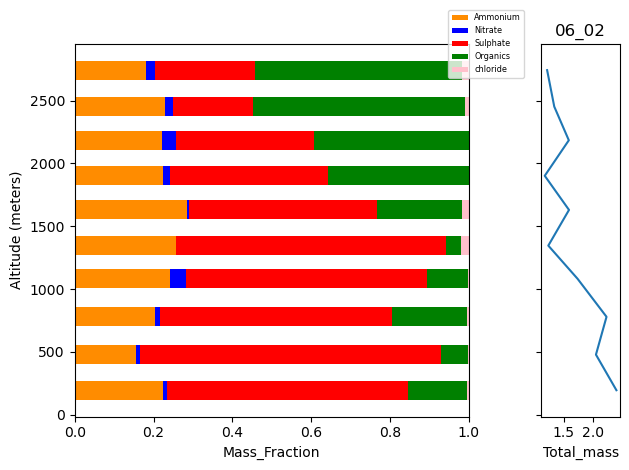

In [439]:
normal = (DAY2_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']+DAY2_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']+DAY2_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']+DAY2_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']+DAY2_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA'])
DAY2_subset_mean['AMS'] = normal
DAY2_subset_mean = DAY2_subset_mean.sort_values(by= 'GPS_Altitude_THORNHILL')
y1 = DAY2_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA']/normal
y2 = DAY2_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']/normal
y3 = DAY2_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']/normal
y4 = DAY2_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']/normal
y5 = DAY2_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']/normal
y6 = DAY2_subset_mean['mz44_Ave_IsoK_STP_ZIEMBA']/normal


fig,ax = plt.subplots(1,2, width_ratios=[20, 4], sharey = "all")
ax[0].barh(DAY2_subset_mean['GPS_Altitude_THORNHILL'], y1, height = 150, color = "darkorange", label = 'Ammonium')
ax[0].barh(DAY2_subset_mean['GPS_Altitude_THORNHILL'], y2, left = y1, height = 150, color = "blue", label = 'Nitrate')
ax[0].barh(DAY2_subset_mean['GPS_Altitude_THORNHILL'], y3, left = y1+y2, height = 150, color = "red", label = 'Sulphate')
ax[0].barh(DAY2_subset_mean['GPS_Altitude_THORNHILL'], y4, left = y1+y2+y3, height = 150, color = "green", label = 'Organics')
#ax.barh(DAY2_subset_mean['GPS_Altitude_THORNHILL'], y6, left = y1+y2+y3, height = 400, color = "palegreen", label = 'mz44')
ax[0].barh(DAY2_subset_mean['GPS_Altitude_THORNHILL'], y5, left = y1+y2+y3+y4, height = 150, color = "pink", label = 'chloride')
ax[1].plot(normal, DAY2_subset_mean['GPS_Altitude_THORNHILL'], label = 'Total_mass')

ax[0].set_ylabel('Altitude (meters)')
ax[0].set_xlabel('Mass_Fraction')
ax[1].set_xlabel('Total_mass')
ax[0].set_xlim(0,1)

ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')
plt.title('06_02')
plt.tight_layout()

In [440]:
DAY2b = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220602_R0_L2_20230614T111634.ict')
start_index = np.where(DAY2b["Time_Start"]==pd.to_datetime("2022-06-02 18:36:00"))
stop_index = np.where(DAY2b["Time_Start"]==pd.to_datetime("2022-06-02 18:53:00"))
DAY2b_subset = DAY2b[start_index[0][0]:stop_index[0][0]]
DAY2b_subset = DAY2b_subset.replace(-888888, 0)
DAY2b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
9180,2022-06-02 18:36:00,2022-06-02 18:36:01,32.312301,-65.009805,191.225,0.669,1.479,-0.051,0.057,0.028,-0.033
9181,2022-06-02 18:36:01,2022-06-02 18:36:02,32.312336,-65.010962,193.480,0.669,1.479,-0.051,0.057,0.028,-0.033
9182,2022-06-02 18:36:02,2022-06-02 18:36:03,32.312332,-65.012116,195.600,0.669,1.479,-0.051,0.057,0.028,-0.033
9183,2022-06-02 18:36:03,2022-06-02 18:36:04,32.312294,-65.013268,197.010,0.669,1.479,-0.051,0.057,0.028,-0.033
9184,2022-06-02 18:36:04,2022-06-02 18:36:05,32.312221,-65.014415,197.440,0.669,1.479,-0.051,0.057,0.028,-0.033
...,...,...,...,...,...,...,...,...,...,...,...
10195,2022-06-02 18:52:55,2022-06-02 18:52:56,32.205808,-64.977280,3678.610,0.836,0.176,0.024,-0.174,-0.012,0.066
10196,2022-06-02 18:52:56,2022-06-02 18:52:57,32.205215,-64.976028,3684.900,0.836,0.176,0.024,-0.174,-0.012,0.066
10197,2022-06-02 18:52:57,2022-06-02 18:52:58,32.204648,-64.974760,3691.340,0.836,0.176,0.024,-0.174,-0.012,0.066
10198,2022-06-02 18:52:58,2022-06-02 18:52:59,32.204104,-64.973478,3697.790,0.836,0.176,0.024,-0.174,-0.012,0.066


In [441]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY2b_subset.GPS_Altitude_THORNHILL.min(), DAY2b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY2b_subset['Bins'] = pd.cut(DAY2b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY2b_subset_1000 = DAY2b_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_1000b = DAY2b_subset_1000[start_index:stop_index]
DAY1000_subset_1000b.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,23,23,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000
mean,2022-06-02 18:38:51.723478272,2022-06-02 18:38:52.723478528,32.264959,-65.002657,542.968740,0.241582,1.147534,-0.017463,0.361457,0.006726,-0.006375
min,2022-06-02 18:36:19.440000,2022-06-02 18:36:20.440000,32.237006,-65.038727,150.110167,-0.179000,0.874000,-0.113000,0.057000,-0.038000,-0.073000
25%,2022-06-02 18:37:45.500000,2022-06-02 18:37:46.500000,32.245356,-65.024746,347.205500,0.097200,1.009000,-0.060000,0.352000,-0.023450,-0.051000
50%,2022-06-02 18:38:58,2022-06-02 18:38:59,32.259206,-65.007059,546.110000,0.284000,1.092615,-0.013000,0.372000,0.014000,0.003000
75%,2022-06-02 18:40:00.750000128,2022-06-02 18:40:01.750000128,32.284653,-64.979873,738.915675,0.393000,1.222000,0.020500,0.447250,0.033651,0.021231
max,2022-06-02 18:41:01.500000,2022-06-02 18:41:02.500000,32.302282,-64.962424,939.254583,0.618200,1.527333,0.084000,0.486000,0.051333,0.068000
std,NaN,NaN,0.021253,0.025022,242.938577,0.216043,0.188750,0.060259,0.123650,0.030089,0.044057


In [442]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3000_subset_3000b = DAY2b_subset_1000[start_index:stop_index]
DAY3000_subset_3000b.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,69,69,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000
mean,2022-06-02 18:47:10.028985344,2022-06-02 18:47:11.028985600,32.292125,-64.972806,2222.171291,0.417963,0.360546,-0.005058,0.140586,0.009712,0.024835
min,2022-06-02 18:41:23,2022-06-02 18:41:24,32.245140,-65.034343,1010.109286,0.099000,0.076000,-0.080000,-0.205000,-0.030000,-0.043000
25%,2022-06-02 18:44:20,2022-06-02 18:44:21,32.265371,-65.005661,1613.940000,0.191000,0.180000,-0.042000,-0.027000,-0.006000,-0.020000
50%,2022-06-02 18:47:13.500000,2022-06-02 18:47:14.500000,32.291366,-64.976928,2220.819167,0.361182,0.236000,-0.004000,0.147000,0.012000,0.004385
75%,2022-06-02 18:50:23.500000,2022-06-02 18:50:24.500000,32.320182,-64.941826,2828.515000,0.521000,0.553000,0.025000,0.312000,0.026000,0.041000
max,2022-06-02 18:52:12,2022-06-02 18:52:13,32.340694,-64.908365,3434.677778,1.357000,0.867714,0.107000,0.552000,0.045000,0.182000
std,NaN,NaN,0.030815,0.037796,716.746439,0.288375,0.224696,0.044561,0.202743,0.021004,0.057277


In [443]:
nbins = 10
bins2b = np.linspace(DAY2b_subset.GPS_Altitude_THORNHILL.min(), DAY2b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY2b_subset['Bins'] = pd.cut(DAY2b_subset['GPS_Altitude_THORNHILL'], bins2b)
DAY2b_subset_mean= DAY2b_subset.groupby('Bins').mean()
DAY2b_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(132.5, 489.666]",2022-06-02 18:37:16.217105408,2022-06-02 18:37:17.217105152,32.266738,-65.013899,277.766842,0.345803,1.332441,0.030395,0.283993,0.024914,0.018164
"(489.666, 846.832]",2022-06-02 18:39:34.500000000,2022-06-02 18:39:35.500000000,32.275278,-65.003346,658.362460,0.248411,1.078548,-0.053492,0.385919,0.000387,-0.027355
"(846.832, 1203.998]",2022-06-02 18:41:27.500000000,2022-06-02 18:41:28.500000000,32.275312,-64.961205,1027.121569,0.166608,0.828098,0.002618,0.283676,-0.006382,-0.009529
"(1203.998, 1561.164]",2022-06-02 18:43:13.500000000,2022-06-02 18:43:14.500000000,32.268556,-64.987369,1380.780182,0.416545,0.598000,-0.026818,0.296909,0.008318,0.055455
"(1561.164, 1918.33]",2022-06-02 18:44:56.000000000,2022-06-02 18:44:57.000000000,32.295981,-64.924398,1745.476105,0.515653,0.463105,0.004284,0.244895,0.022253,0.034905
"(1918.33, 2275.496]",2022-06-02 18:46:35.499999744,2022-06-02 18:46:36.500000256,32.325801,-65.004061,2098.379231,0.967846,0.421394,0.051875,-0.055500,-0.010385,0.133519
"(2275.496, 2632.662]",2022-06-02 18:48:22.500000000,2022-06-02 18:48:23.499999744,32.256820,-64.976159,2462.503000,0.325973,0.136955,-0.018691,-0.090882,-0.005427,-0.000264
"(2632.662, 2989.828]",2022-06-02 18:50:07.000000000,2022-06-02 18:50:07.999999744,32.315637,-64.932314,2788.535960,0.392697,0.141121,-0.017818,0.167788,0.020909,-0.013152
"(2989.828, 3346.994]",2022-06-02 18:51:26.500000000,2022-06-02 18:51:27.500000000,32.299653,-65.001226,3160.220167,0.169967,0.186367,-0.043367,0.240867,0.025600,-0.026533


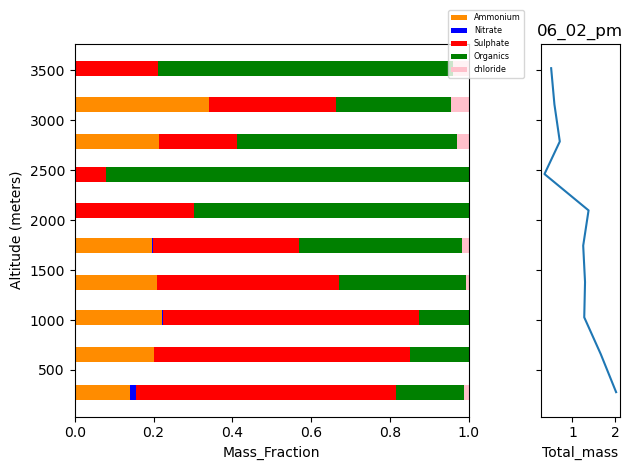

In [444]:
normal = (DAY2b_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']+DAY2b_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']+DAY2b_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']+DAY2b_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']+DAY2b_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA'])
DAY2b_subset_mean['AMS'] = normal
DAY2b_subset_mean = DAY2b_subset_mean.sort_values(by= 'GPS_Altitude_THORNHILL')
y1 = DAY2b_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA']/normal
y2 = DAY2b_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']/normal
y3 = DAY2b_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']/normal
y4 = DAY2b_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']/normal
y5 = DAY2b_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']/normal
y6 = DAY2b_subset_mean['mz44_Ave_IsoK_STP_ZIEMBA']/normal


fig,ax = plt.subplots(1,2, width_ratios=[20, 4], sharey = "all")
ax[0].barh(DAY2b_subset_mean['GPS_Altitude_THORNHILL'], y1, height = 150, color = "darkorange", label = 'Ammonium')
ax[0].barh(DAY2b_subset_mean['GPS_Altitude_THORNHILL'], y2, left = y1, height = 150, color = "blue", label = 'Nitrate')
ax[0].barh(DAY2b_subset_mean['GPS_Altitude_THORNHILL'], y3, left = y1+y2, height = 150, color = "red", label = 'Sulphate')
ax[0].barh(DAY2b_subset_mean['GPS_Altitude_THORNHILL'], y4, left = y1+y2+y3, height = 150, color = "green", label = 'Organics')
#ax.barh(DAY2b_subset_mean['GPS_Altitude_THORNHILL'], y6, left = y1+y2+y3, height = 400, color = "palegreen", label = 'mz44')
ax[0].barh(DAY2b_subset_mean['GPS_Altitude_THORNHILL'], y5, left = y1+y2+y3+y4, height = 150, color = "pink", label = 'chloride')
ax[1].plot(normal, DAY2b_subset_mean['GPS_Altitude_THORNHILL'], label = 'Total_mass')

ax[0].set_ylabel('Altitude (meters)')
ax[0].set_xlabel('Mass_Fraction')
ax[1].set_xlabel('Total_mass')
ax[0].set_xlim(0,1)

ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')
plt.title('06_02_pm')
plt.tight_layout()

In [445]:
DAY3 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220603_R0_20230614T111635.ict')
start_index= np.where(DAY3["Time_Start"]==pd.to_datetime("2022-06-03 13:30:00"))
stop_index= np.where(DAY3["Time_Start"]==pd.to_datetime("2022-06-03 15:00:00"))
    
DAY3_subset = DAY3[start_index[0][0]:stop_index[0][0]]
DAY3_subset = DAY3_subset.replace(-888888, 0)
DAY3_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
2467,2022-06-03 13:30:00,2022-06-03 13:30:01,33.872982,-67.052387,2858.90,0.343,0.244,-0.017,0.025,-0.002,0.050
2468,2022-06-03 13:30:01,2022-06-03 13:30:02,33.872534,-67.053832,2861.55,0.343,0.244,-0.017,0.025,-0.002,0.050
2469,2022-06-03 13:30:02,2022-06-03 13:30:03,33.872086,-67.055272,2863.82,0.343,0.244,-0.017,0.025,-0.002,0.050
2470,2022-06-03 13:30:03,2022-06-03 13:30:04,33.871638,-67.056704,2865.57,0.343,0.244,-0.017,0.025,-0.002,0.050
2471,2022-06-03 13:30:04,2022-06-03 13:30:05,33.871187,-67.058127,2866.59,0.343,0.244,-0.017,0.025,-0.002,0.050
...,...,...,...,...,...,...,...,...,...,...,...
7862,2022-06-03 14:59:55,2022-06-03 14:59:56,32.712767,-65.244314,2413.61,0.003,0.199,0.020,0.215,0.022,-0.014
7863,2022-06-03 14:59:56,2022-06-03 14:59:57,32.712103,-65.243151,2408.15,0.003,0.199,0.020,0.215,0.022,-0.014
7864,2022-06-03 14:59:57,2022-06-03 14:59:58,32.711441,-65.241989,2402.02,0.003,0.199,0.020,0.215,0.022,-0.014
7865,2022-06-03 14:59:58,2022-06-03 14:59:59,32.710779,-65.240827,2395.43,0.003,0.199,0.020,0.215,0.022,-0.014


In [446]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY3_subset.GPS_Altitude_THORNHILL.min(), DAY3_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY3_subset['Bins'] = pd.cut(DAY3_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY3_subset_1000 = DAY3_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY3_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY3_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_3 = DAY3_subset_1000[start_index:stop_index]
DAY1000_subset_3.describe()


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,15,15,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,2022-06-03 13:59:06.075923200,2022-06-03 13:59:07.075923200,34.031974,-67.313292,509.475320,0.305188,1.204640,0.019582,0.325971,0.002886,0.020019
min,2022-06-03 13:45:28.789007104,2022-06-03 13:45:29.789007104,33.896819,-67.436618,123.892358,0.013037,0.783597,-0.018927,0.246444,-0.039839,-0.065333
25%,2022-06-03 13:53:04.551072768,2022-06-03 13:53:05.551072256,33.918176,-67.382184,310.448520,0.154304,0.930993,0.014915,0.274780,-0.000391,0.013825
50%,2022-06-03 13:56:08.066666752,2022-06-03 13:56:09.066666752,34.037034,-67.347328,500.509848,0.345738,1.318320,0.017182,0.317101,0.004714,0.020461
75%,2022-06-03 14:02:02.152476672,2022-06-03 14:02:03.152476672,34.125040,-67.257131,697.796486,0.425481,1.438419,0.027684,0.372072,0.010622,0.032199
max,2022-06-03 14:20:26.274193664,2022-06-03 14:20:27.274193408,34.214933,-67.060673,898.644167,0.647220,1.663827,0.077060,0.418089,0.020222,0.077720
std,NaN,NaN,0.113846,0.104075,246.500338,0.185149,0.290747,0.021927,0.060309,0.014645,0.029065


In [447]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY3_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY3_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3_subset_3000 = DAY3_subset_1000[start_index:stop_index]
DAY3_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,45,45,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
mean,2022-06-03 14:17:53.347165952,2022-06-03 14:17:54.347165952,33.699769,-66.823042,2214.439586,0.470681,0.492224,0.028883,0.254743,0.000570,0.049067
min,2022-06-03 13:53:27.769230848,2022-06-03 13:53:28.769230592,32.986787,-67.516110,1004.015000,-0.002429,0.162333,-0.072333,0.051435,-0.021200,-0.083111
25%,2022-06-03 14:00:02.636363520,2022-06-03 14:00:03.636363520,33.409507,-67.254654,1592.160263,0.247333,0.358550,-0.006000,0.165000,-0.007156,-0.003000
50%,2022-06-03 14:11:07.307692288,2022-06-03 14:11:08.307692288,33.878409,-67.028103,2212.072222,0.443000,0.509852,0.029733,0.233857,-0.004273,0.046154
75%,2022-06-03 14:28:57.095238144,2022-06-03 14:28:58.095237888,33.996922,-66.454962,2821.081500,0.725684,0.695222,0.058437,0.319526,0.009524,0.113111
max,2022-06-03 14:54:11.565217536,2022-06-03 14:54:12.565217536,34.194709,-65.729004,3427.270000,1.005000,0.855500,0.115273,0.510000,0.024667,0.163545
std,NaN,NaN,0.354658,0.503728,723.872134,0.290315,0.212912,0.046269,0.124563,0.012570,0.068298


In [448]:
nbins = 10
bins3 = np.linspace(DAY3_subset.GPS_Altitude_THORNHILL.min(), DAY3_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY3_subset['Bins'] = pd.cut(DAY3_subset['GPS_Altitude_THORNHILL'], bins3)
DAY3_subset_mean= DAY3_subset.groupby('Bins').mean()
DAY3_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(94.825, 645.478]",2022-06-03 13:54:50.131944448,2022-06-03 13:54:51.131944448,34.118241,-67.281945,258.679246,0.476539,1.435846,0.022747,0.361183,0.003899,0.028944
"(645.478, 1196.13]",2022-06-03 14:16:04.188321280,2022-06-03 14:16:05.188321280,34.087969,-67.399556,921.022314,0.371798,0.822881,-0.000351,0.244643,-0.005663,0.013652
"(1196.13, 1746.782]",2022-06-03 14:22:33.749999872,2022-06-03 14:22:34.749999872,34.157475,-67.221725,1521.900125,0.804718,0.675548,0.015389,0.308559,-0.011316,0.109625
"(1746.782, 2297.435]",2022-06-03 13:58:42.865384448,2022-06-03 13:58:43.865384448,33.892156,-67.253290,2013.967115,0.758317,0.717019,0.061721,0.379192,0.005577,0.120606
"(2297.435, 2848.088]",2022-06-03 14:21:21.184782592,2022-06-03 14:21:22.184782592,33.503868,-66.585250,2593.513370,0.644446,0.435609,0.060440,0.192690,0.015739,0.091402
"(2848.088, 3398.74]",2022-06-03 14:45:59.751552768,2022-06-03 14:46:00.751552768,33.197365,-66.082539,3100.264099,0.137236,0.191385,0.023280,0.120031,-0.005453,0.001720
"(3398.74, 3949.392]",2022-06-03 14:48:19.629629440,2022-06-03 14:48:20.629629696,33.287324,-66.251799,3672.274383,0.177599,0.156722,-0.042685,0.273506,-0.008309,-0.020512
"(3949.392, 4500.045]",2022-06-03 14:46:56.755725312,2022-06-03 14:46:57.755725056,33.356680,-66.373429,4228.885725,0.379366,0.214855,-0.012664,0.179794,0.014076,-0.004588
"(4500.045, 5050.698]",2022-06-03 14:45:59.229299456,2022-06-03 14:46:00.229299200,33.407839,-66.461780,4786.661847,0.370841,0.222159,-0.005280,0.097325,-0.006096,0.018771


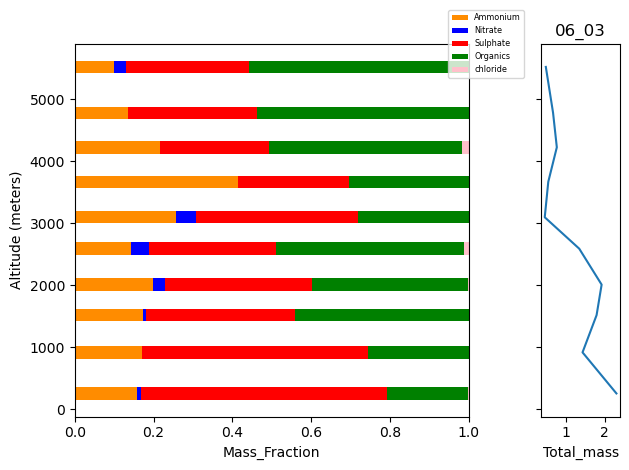

In [449]:
normal3 = (DAY3_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']+DAY3_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']+DAY3_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']+DAY3_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']+DAY3_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA'])
DAY3_subset_mean['AMS'] = normal3
DAY3_subset_mean = DAY3_subset_mean.sort_values(by= 'GPS_Altitude_THORNHILL')
y1 = DAY3_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA']/normal3
y2 = DAY3_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']/normal3
y3 = DAY3_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']/normal3
y4 = DAY3_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']/normal3
y5 = DAY3_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']/normal3
y6 = DAY3_subset_mean['mz44_Ave_IsoK_STP_ZIEMBA']/normal3
fig,ax = plt.subplots(1,2, width_ratios=[20, 4], sharey = "all")
ax[0].barh(DAY3_subset_mean['GPS_Altitude_THORNHILL'], y1, height = 200, color = "darkorange", label = 'Ammonium')
ax[0].barh(DAY3_subset_mean['GPS_Altitude_THORNHILL'], y2, left = y1, height = 200, color = "blue", label = 'Nitrate')
ax[0].barh(DAY3_subset_mean['GPS_Altitude_THORNHILL'], y3, left = y1+y2, height = 200, color = "red", label = 'Sulphate')
ax[0].barh(DAY3_subset_mean['GPS_Altitude_THORNHILL'], y4, left = y1+y2+y3, height = 200, color = "green", label = 'Organics')
#ax.barh(DAY3_subset_mean[' GPS_Altitude_THORNHILL'], y6, left = y1+y2+y3, height = 400, color = "palegreen", label = 'mz44')
ax[0].barh(DAY3_subset_mean['GPS_Altitude_THORNHILL'], y5, left = y1+y2+y3+y4, height = 200, color = "pink", label = 'chloride')
ax[1].plot(normal3, DAY3_subset_mean['GPS_Altitude_THORNHILL'], label = 'Total_mass')

ax[0].set_ylabel('Altitude (meters)')
ax[0].set_xlabel('Mass_Fraction')
ax[1].set_xlabel('Total_mass')
ax[1].set_xlabel('Total_mass')
ax[0].set_xlim(0,1)
plt.title('06_03')

ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')
plt.tight_layout()

In [450]:
DAY7 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220607_R0_L1_20230614T111635.ict')
start_index = np.where(DAY7["Time_Start"]==pd.to_datetime("2022-06-07 14:32:00"))
stop_index = np.where(DAY7["Time_Start"]==pd.to_datetime("2022-06-07 14:47:00"))
    
DAY7_subset =DAY7[start_index[0][0]:stop_index[0][0]]
DAY7_subset = DAY7_subset.replace(-888888, 0)
DAY7_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
10397,2022-06-07 14:32:00,2022-06-07 14:32:01,32.250498,-64.999220,127.595,1.99,0.94,0.086,0.069,0.008,0.245
10398,2022-06-07 14:32:01,2022-06-07 14:32:02,32.249883,-64.998233,126.585,1.99,0.94,0.086,0.069,0.008,0.245
10399,2022-06-07 14:32:02,2022-06-07 14:32:03,32.249267,-64.997244,125.870,1.99,0.94,0.086,0.069,0.008,0.245
10400,2022-06-07 14:32:03,2022-06-07 14:32:04,32.248648,-64.996254,125.955,1.99,0.94,0.086,0.069,0.008,0.245
10401,2022-06-07 14:32:04,2022-06-07 14:32:05,32.248027,-64.995263,126.990,1.99,0.94,0.086,0.069,0.008,0.245
...,...,...,...,...,...,...,...,...,...,...,...
11292,2022-06-07 14:46:55,2022-06-07 14:46:56,32.255021,-64.999573,2800.660,0.46,0.33,0.027,-0.270,-0.026,0.072
11293,2022-06-07 14:46:56,2022-06-07 14:46:57,32.255098,-64.998248,2805.770,0.46,0.33,0.027,-0.270,-0.026,0.072
11294,2022-06-07 14:46:57,2022-06-07 14:46:58,32.255152,-64.996919,2810.920,0.46,0.33,0.027,-0.270,-0.026,0.072
11295,2022-06-07 14:46:58,2022-06-07 14:46:59,32.255184,-64.995588,2816.140,0.46,0.33,0.027,-0.270,-0.026,0.072


In [451]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY7_subset.GPS_Altitude_THORNHILL.min(), DAY7_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY7_subset['Bins'] = pd.cut(DAY7_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY7_subset_1000 = DAY7_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_7 = DAY7_subset_1000[start_index:stop_index]
DAY1000_subset_7.describe()


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,32,32,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,2022-06-07 14:35:00.040624896,2022-06-07 14:35:01.040625152,32.203969,-65.014365,556.934717,2.239672,1.061914,0.092989,0.553051,0.023290,0.305073
min,2022-06-07 14:32:05.300000,2022-06-07 14:32:06.300000,32.170582,-65.065238,134.321500,1.900000,0.978400,0.060000,0.149700,-0.010000,0.242000
25%,2022-06-07 14:33:35,2022-06-07 14:33:36,32.183216,-65.041953,347.163917,2.184250,0.997575,0.065750,0.448750,0.010000,0.283775
50%,2022-06-07 14:35:00,2022-06-07 14:35:01,32.200789,-65.011491,556.984256,2.293855,1.054625,0.087100,0.527428,0.019000,0.296500
75%,2022-06-07 14:36:28.375000064,2022-06-07 14:36:29.375000064,32.223952,-64.985716,766.155767,2.337545,1.087932,0.100161,0.668000,0.030409,0.333000
max,2022-06-07 14:37:53,2022-06-07 14:37:54,32.247173,-64.972505,975.912308,2.362000,1.214000,0.184000,0.834000,0.076000,0.372000
std,NaN,NaN,0.023321,0.030095,253.301933,0.131985,0.067053,0.032566,0.167091,0.019913,0.038019


In [452]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY7_subset_3000 = DAY7_subset_1000[start_index:stop_index]
DAY7_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,66,66,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000
mean,2022-06-07 14:42:59.749999872,2022-06-07 14:43:00.749999872,32.216037,-65.019964,1904.958410,1.011152,0.448017,0.001768,0.258644,-0.007158,0.105428
min,2022-06-07 14:38:12,2022-06-07 14:38:13,32.162806,-65.062171,1029.744286,0.456000,0.131000,-0.093000,-0.270000,-0.047000,0.031000
25%,2022-06-07 14:40:40.875000064,2022-06-07 14:40:41.875000064,32.191330,-65.049738,1465.722889,0.654000,0.204500,-0.028000,0.083000,-0.026000,0.066938
50%,2022-06-07 14:43:15,2022-06-07 14:43:16,32.220456,-65.024030,1904.433889,1.078875,0.303200,0.014000,0.248000,-0.016000,0.088250
75%,2022-06-07 14:45:30.375000064,2022-06-07 14:45:31.375000064,32.243509,-64.990932,2342.021375,1.274969,0.443909,0.044000,0.439182,0.009000,0.143000
max,2022-06-07 14:46:51,2022-06-07 14:46:52,32.254471,-64.960247,2779.770000,1.648000,1.356000,0.088000,0.663000,0.043000,0.197000
std,NaN,NaN,0.029303,0.032155,517.347289,0.356723,0.370514,0.052139,0.245120,0.026264,0.046331


In [453]:
nbins = 10
bins7 = np.linspace(DAY7_subset.GPS_Altitude_THORNHILL.min(), DAY7_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY7_subset['Bins'] = pd.cut(DAY7_subset['GPS_Altitude_THORNHILL'], bins7)
DAY7_subset_mean = DAY7_subset.groupby('Bins').mean()
DAY7_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(125.87, 395.426]",2022-06-07 14:32:55.981981952,2022-06-07 14:32:56.981981952,32.205538,-64.991604,258.876126,2.271820,1.034360,0.077315,0.578189,0.027207,0.308820
"(395.426, 664.982]",2022-06-07 14:34:49.000000000,2022-06-07 14:34:50.000000000,32.220630,-65.026236,531.635348,2.201243,1.019739,0.089061,0.471417,0.012600,0.326383
"(664.982, 934.538]",2022-06-07 14:36:42.000000000,2022-06-07 14:36:43.000000000,32.184879,-65.013616,799.374775,2.319054,1.120964,0.117027,0.631712,0.031811,0.296009
"(934.538, 1204.094]",2022-06-07 14:38:26.500000000,2022-06-07 14:38:27.500000000,32.235426,-65.046446,1067.856684,1.401816,1.235347,0.064765,0.502867,0.014714,0.166204
"(1204.094, 1473.65]",2022-06-07 14:39:59.500000000,2022-06-07 14:40:00.500000000,32.211566,-64.994325,1341.217273,1.362250,0.730784,0.042420,0.522943,0.007375,0.156057
"(1473.65, 1743.206]",2022-06-07 14:41:31.500000000,2022-06-07 14:41:32.500000000,32.212630,-65.049610,1612.559792,1.349323,0.256635,0.022292,0.272417,0.005990,0.151448
"(1743.206, 2012.762]",2022-06-07 14:43:04.500000000,2022-06-07 14:43:05.500000000,32.234663,-64.984944,1872.815444,1.127122,0.215811,0.002900,0.060622,-0.018478,0.066467
"(2012.762, 2282.318]",2022-06-07 14:44:31.000000000,2022-06-07 14:44:32.000000000,32.171841,-64.998133,2148.726747,0.924578,0.320687,-0.001964,0.276060,0.004458,0.077867
"(2282.318, 2551.874]",2022-06-07 14:45:41.000000000,2022-06-07 14:45:42.000000000,32.201458,-65.054735,2405.892982,0.528842,0.310667,-0.062421,0.278491,-0.027456,0.082246


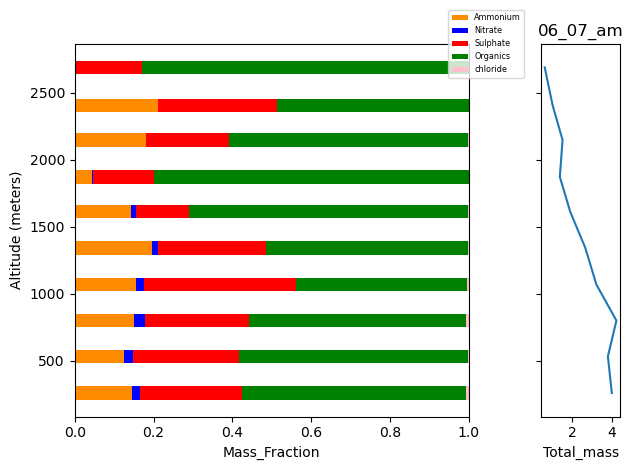

In [454]:
normal7 = (DAY7_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']+DAY7_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']+DAY7_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']+DAY7_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']+DAY7_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA'])
DAY7_subset_mean['AMS'] = normal7
DAY7_subset_mean = DAY7_subset_mean.sort_values(by= 'GPS_Altitude_THORNHILL')
y1 = DAY7_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA']/normal7
y2 = DAY7_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']/normal7
y3 = DAY7_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']/normal7
y4 = DAY7_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']/normal7
y5 = DAY7_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']/normal7
y6 = DAY7_subset_mean['mz44_Ave_IsoK_STP_ZIEMBA']/normal7
fig,ax = plt.subplots(1,2, width_ratios=[20, 4], sharey = "all")
ax[0].barh(DAY7_subset_mean['GPS_Altitude_THORNHILL'], y1, height = 100, color = "darkorange", label = 'Ammonium')
ax[0].barh(DAY7_subset_mean['GPS_Altitude_THORNHILL'], y2, left = y1, height = 100, color = "blue", label = 'Nitrate')
ax[0].barh(DAY7_subset_mean['GPS_Altitude_THORNHILL'], y3, left = y1+y2, height = 100, color = "red", label = 'Sulphate')
ax[0].barh(DAY7_subset_mean['GPS_Altitude_THORNHILL'], y4, left = y1+y2+y3, height = 100, color = "green", label = 'Organics')
#ax.barh(DAY7_subset_mean[' GPS_Altitude_THORNHILL'], y6, left = y1+y2+y3, height = 400, color = "palegreen", label = 'mz44')
ax[0].barh(DAY7_subset_mean['GPS_Altitude_THORNHILL'], y5, left = y1+y2+y3+y4, height = 100, color = "pink", label = 'chloride')
ax[1].plot(normal7, DAY7_subset_mean['GPS_Altitude_THORNHILL'], label = 'Total_mass')

ax[0].set_ylabel('Altitude (meters)')
ax[0].set_xlabel('Mass_Fraction')
ax[1].set_xlabel('Total_mass')
ax[0].set_xlim(0,1)
plt.title('06_07_am')

ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')
plt.tight_layout()

In [455]:
DAY7b = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220607_R0_L2_20230614T111635.ict')
start_index = np.where(DAY7b["Time_Start"]==pd.to_datetime("2022-06-07 19:08:00"))
stop_index = np.where(DAY7b["Time_Start"]==pd.to_datetime("2022-06-07 19:23:00"))
    
DAY7b_subset = DAY7b[start_index[0][0]:stop_index[0][0]]
DAY7b_subset = DAY7b_subset.replace(-888888, 0)
DAY7b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
10420,2022-06-07 19:08:00,2022-06-07 19:08:01,32.242823,-65.003952,133.320,0.875,0.562,0.050,0.120,0.004,0.077
10421,2022-06-07 19:08:01,2022-06-07 19:08:02,32.243085,-65.002775,133.120,0.875,0.562,0.050,0.120,0.004,0.077
10422,2022-06-07 19:08:02,2022-06-07 19:08:03,32.243347,-65.001596,132.930,0.875,0.562,0.050,0.120,0.004,0.077
10423,2022-06-07 19:08:03,2022-06-07 19:08:04,32.243610,-65.000416,132.720,0.875,0.562,0.050,0.120,0.004,0.077
10424,2022-06-07 19:08:04,2022-06-07 19:08:05,32.243873,-64.999235,132.595,0.875,0.562,0.050,0.120,0.004,0.077
...,...,...,...,...,...,...,...,...,...,...,...
11315,2022-06-07 19:22:55,2022-06-07 19:22:56,32.296480,-65.011792,3518.030,0.538,0.199,0.045,0.271,0.004,0.148
11316,2022-06-07 19:22:56,2022-06-07 19:22:57,32.296519,-65.013093,3524.890,0.538,0.199,0.045,0.271,0.004,0.148
11317,2022-06-07 19:22:57,2022-06-07 19:22:58,32.296518,-65.014396,3531.840,0.538,0.199,0.045,0.271,0.004,0.148
11318,2022-06-07 19:22:58,2022-06-07 19:22:59,32.296479,-65.015699,3538.850,0.538,0.199,0.045,0.271,0.004,0.148


In [456]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY7b_subset.GPS_Altitude_THORNHILL.min(), DAY7b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY7b_subset['Bins'] = pd.cut(DAY7b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY7b_subset_1000 = DAY7b_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_7b = DAY7b_subset_1000[start_index:stop_index]
DAY1000_subset_7b.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,24,24,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,2022-06-07 19:10:10.073529344,2022-06-07 19:10:11.073529088,32.266668,-65.007084,541.993433,0.976279,0.601397,0.065631,0.139755,0.003925,0.096298
min,2022-06-07 19:08:08.764705792,2022-06-07 19:08:09.764706048,32.234380,-65.053370,142.995294,0.743000,0.449000,0.013000,-0.006000,-0.033000,0.066000
25%,2022-06-07 19:09:09.375000064,2022-06-07 19:09:10.375000064,32.247399,-65.033467,345.866146,0.905975,0.513773,0.040000,0.051833,-0.008000,0.076500
50%,2022-06-07 19:10:12.249999872,2022-06-07 19:10:13.249999872,32.265216,-64.998511,542.307523,0.981000,0.571700,0.061709,0.146455,0.002676,0.094227
75%,2022-06-07 19:11:09.500000,2022-06-07 19:11:10.500000,32.283971,-64.980836,738.611174,1.021636,0.619139,0.106000,0.234500,0.011652,0.115000
max,2022-06-07 19:12:08,2022-06-07 19:12:09,32.302506,-64.972311,935.982778,1.213000,0.891000,0.136000,0.278000,0.044000,0.141000
std,NaN,NaN,0.022943,0.029019,241.840005,0.131483,0.129446,0.038919,0.096325,0.021377,0.023202


In [457]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY7b_subset_3000 = DAY7b_subset_1000[start_index:stop_index]
DAY7b_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,73,73,73.000000,73.000000,73.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000
mean,2022-06-07 19:18:29.986301184,2022-06-07 19:18:30.986301440,32.257889,-65.013035,2231.494696,0.713215,0.308433,0.030655,0.248259,0.016204,0.087679
min,2022-06-07 19:12:28.500000,2022-06-07 19:12:29.500000,32.216667,-65.060683,1003.411000,0.226000,0.098000,-0.037000,-0.067000,-0.035000,0.000000
25%,2022-06-07 19:15:47,2022-06-07 19:15:48,32.232928,-65.040904,1617.601818,0.491500,0.146000,0.010667,0.065000,0.003231,0.026000
50%,2022-06-07 19:19:20,2022-06-07 19:19:21,32.257599,-65.010363,2230.995455,0.596000,0.237000,0.037000,0.208000,0.018000,0.080727
75%,2022-06-07 19:21:12.500000,2022-06-07 19:21:13.500000,32.283190,-64.983953,2846.185000,0.914000,0.300000,0.057727,0.482750,0.028000,0.123000
max,2022-06-07 19:22:46,2022-06-07 19:22:47,32.300554,-64.969690,3459.904000,1.590000,1.295000,0.108000,0.563000,0.045000,0.239000
std,NaN,NaN,0.026111,0.029529,724.229273,0.374971,0.302657,0.037189,0.214246,0.019562,0.063048


In [458]:
nbins = 10
bins7b = np.linspace(DAY7b_subset.GPS_Altitude_THORNHILL.min(), DAY7b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY7b_subset['Bins'] = pd.cut(DAY7b_subset['GPS_Altitude_THORNHILL'], bins7b)
DAY7b_subset_mean = DAY7b_subset.groupby('Bins').mean()
DAY7b_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(132.595, 473.926]",2022-06-07 19:08:55.463636480,2022-06-07 19:08:56.463636224,32.279306,-64.993026,296.716545,0.936445,0.515709,0.056945,0.184218,0.007791,0.091273
"(473.926, 815.256]",2022-06-07 19:10:40.500000000,2022-06-07 19:10:41.500000000,32.254455,-65.033104,640.184650,0.953800,0.592030,0.068560,0.147130,0.007920,0.096250
"(815.256, 1156.586]",2022-06-07 19:12:23.500000000,2022-06-07 19:12:24.500000000,32.282477,-65.003299,986.855849,1.388519,1.069896,0.071330,0.136642,-0.006340,0.168613
"(1156.586, 1497.917]",2022-06-07 19:14:12.500000000,2022-06-07 19:14:13.500000000,32.247663,-65.028547,1322.901607,0.917804,0.391482,0.032929,0.290705,0.028116,0.118429
"(1497.917, 1839.248]",2022-06-07 19:16:05.500000000,2022-06-07 19:16:06.500000000,32.279859,-65.022303,1673.998596,0.590000,0.266000,0.046000,0.017000,0.000000,0.096000
"(1839.248, 2180.578]",2022-06-07 19:18:01.999999744,2022-06-07 19:18:03.000000000,32.241752,-65.004495,2004.607647,0.594453,0.212509,0.031236,0.071962,-0.001868,0.101943
"(2180.578, 2521.908]",2022-06-07 19:19:42.000000000,2022-06-07 19:19:43.000000000,32.278778,-65.019786,2318.329012,0.517086,0.175531,0.064086,0.090111,0.006000,0.031420
"(2521.908, 2863.239]",2022-06-07 19:20:49.000000000,2022-06-07 19:20:50.000000000,32.227765,-65.035262,2691.864151,0.770906,0.253962,0.048887,0.554321,0.028000,0.103906
"(2863.239, 3204.57]",2022-06-07 19:21:41.000000000,2022-06-07 19:21:42.000000000,32.235981,-64.983314,3033.278039,0.696725,0.203294,0.010118,0.208157,0.028588,0.080824


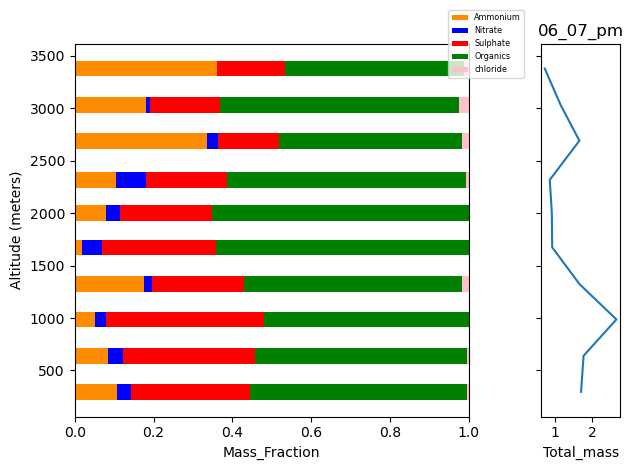

In [459]:
normal7b = (DAY7b_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']+DAY7b_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']+DAY7b_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']+DAY7b_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']+DAY7b_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA'])
DAY7b_subset_mean['AMS'] = normal7b
DAY7b_subset_mean = DAY7b_subset_mean.sort_values(by= 'GPS_Altitude_THORNHILL')
y1 = DAY7b_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA']/normal7b
y2 = DAY7b_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']/normal7b
y3 = DAY7b_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']/normal7b
y4 = DAY7b_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']/normal7b
y5 = DAY7b_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']/normal7b
y6 = DAY7b_subset_mean['mz44_Ave_IsoK_STP_ZIEMBA']/normal7b
fig,ax = plt.subplots(1,2, width_ratios=[20, 4], sharey = "all")
ax[0].barh(DAY7b_subset_mean['GPS_Altitude_THORNHILL'], y1, height = 150, color = "darkorange", label = 'Ammonium')
ax[0].barh(DAY7b_subset_mean['GPS_Altitude_THORNHILL'], y2, left = y1, height = 150, color = "blue", label = 'Nitrate')
ax[0].barh(DAY7b_subset_mean['GPS_Altitude_THORNHILL'], y3, left = y1+y2, height = 150, color = "red", label = 'Sulphate')
ax[0].barh(DAY7b_subset_mean['GPS_Altitude_THORNHILL'], y4, left = y1+y2+y3, height = 150, color = "green", label = 'Organics')
#ax.barh(DAY7b_subset_mean['GPS_Altitude_THORNHILL'], y6, left = y1+y2+y3, height = 400, color = "palegreen", label = 'mz44')
ax[0].barh(DAY7b_subset_mean['GPS_Altitude_THORNHILL'], y5, left = y1+y2+y3+y4, height = 150, color = "pink", label = 'chloride')
ax[1].plot(normal7b, DAY7b_subset_mean['GPS_Altitude_THORNHILL'], label = 'Total_mass')

ax[0].set_ylabel('Altitude (meters)')
ax[0].set_xlabel('Mass_Fraction')
ax[1].set_xlabel('Total_mass')
ax[0].set_xlim(0,1)
plt.title('06_07_pm')

ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')
plt.tight_layout()

In [460]:
DAY8 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220608_R0_L2_20230614T111636.ict')
start_index = np.where(DAY8["Time_Start"]==pd.to_datetime("2022-06-08 20:30:00"))
stop_index = np.where(DAY8["Time_Start"]==pd.to_datetime("2022-06-08 20:45:00"))
    
DAY8_subset = DAY8[start_index[0][0]:stop_index[0][0]]
DAY8_subset = DAY8_subset.replace(-888888, 0)
DAY8_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
10668,2022-06-08 20:30:00,2022-06-08 20:30:01,32.267080,-64.998961,152.725,1.050,1.150,0.088,0.330,0.037,0.169
10669,2022-06-08 20:30:01,2022-06-08 20:30:02,32.268158,-64.999178,153.350,1.050,1.150,0.088,0.330,0.037,0.169
10670,2022-06-08 20:30:02,2022-06-08 20:30:03,32.269234,-64.999434,153.870,1.050,1.150,0.088,0.330,0.037,0.169
10671,2022-06-08 20:30:03,2022-06-08 20:30:04,32.270310,-64.999724,154.255,1.050,1.150,0.088,0.330,0.037,0.169
10672,2022-06-08 20:30:04,2022-06-08 20:30:05,32.271382,-65.000051,154.510,1.050,1.150,0.088,0.330,0.037,0.169
...,...,...,...,...,...,...,...,...,...,...,...
11563,2022-06-08 20:44:55,2022-06-08 20:44:56,32.251172,-65.086081,3838.620,0.153,0.308,0.063,0.185,-0.003,0.050
11564,2022-06-08 20:44:56,2022-06-08 20:44:57,32.250122,-65.085465,3847.170,0.153,0.308,0.063,0.185,-0.003,0.050
11565,2022-06-08 20:44:57,2022-06-08 20:44:58,32.249088,-65.084808,3855.660,0.153,0.308,0.063,0.185,-0.003,0.050
11566,2022-06-08 20:44:58,2022-06-08 20:44:59,32.248074,-65.084107,3864.100,0.153,0.308,0.063,0.185,-0.003,0.050


In [461]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY8_subset.GPS_Altitude_THORNHILL.min(), DAY8_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY8_subset['Bins'] = pd.cut(DAY8_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY8_subset_1000 = DAY8_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_8 = DAY8_subset_1000[start_index:stop_index]
DAY1000_subset_8.describe()


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,22,22,22.000000,22.000000,22.000000,22.000000,22.000000,22.00000,22.000000,22.000000,22.000000
mean,2022-06-08 20:32:55.875598080,2022-06-08 20:32:56.875598080,32.280714,-65.050261,556.617178,0.871977,1.366537,0.03100,0.150281,-0.004818,0.119464
min,2022-06-08 20:30:28.263158016,2022-06-08 20:30:29.263158016,32.240992,-65.089810,156.621053,0.467000,1.194088,-0.02500,-0.183000,-0.030000,0.076000
25%,2022-06-08 20:31:57,2022-06-08 20:31:58,32.255180,-65.076734,361.598875,0.864750,1.308000,0.00730,-0.013500,-0.010659,0.098100
50%,2022-06-08 20:32:55.249999872,2022-06-08 20:32:56.249999872,32.283625,-65.054096,557.482614,0.898800,1.338000,0.03560,0.210100,-0.006000,0.118500
75%,2022-06-08 20:33:58.750000128,2022-06-08 20:33:59.750000128,32.302411,-65.021867,752.755000,0.995846,1.393405,0.05500,0.313423,0.002000,0.136462
max,2022-06-08 20:34:59,2022-06-08 20:35:00,32.321613,-65.006859,947.486818,1.078930,1.635000,0.06100,0.358000,0.020386,0.168000
std,NaN,NaN,0.027820,0.029324,242.789874,0.168146,0.122852,0.02702,0.182231,0.013684,0.025818


In [462]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY8_subset_3000 = DAY8_subset_1000[start_index:stop_index]
DAY8_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,66,66,66.000000,66.000000,66.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000
mean,2022-06-08 20:40:35.712121088,2022-06-08 20:40:36.712120832,32.267574,-65.045738,2233.285641,0.650548,0.405310,0.004318,0.185304,0.011657,0.088949
min,2022-06-08 20:35:22,2022-06-08 20:35:23,32.228886,-65.089712,1020.976364,0.111000,0.207000,-0.091000,-0.058000,-0.037000,-0.020000
25%,2022-06-08 20:38:33.750000128,2022-06-08 20:38:34.750000128,32.248320,-65.066839,1629.684000,0.305000,0.253000,-0.029000,0.041000,0.002000,0.047000
50%,2022-06-08 20:40:58,2022-06-08 20:40:59,32.268545,-65.043980,2235.469949,0.699000,0.296833,0.011000,0.173000,0.013000,0.089000
75%,2022-06-08 20:42:54.375000064,2022-06-08 20:42:55.375000064,32.288503,-65.022374,2837.283250,0.944000,0.412000,0.031000,0.311000,0.023000,0.129000
max,2022-06-08 20:44:08.500000,2022-06-08 20:44:09.500000,32.305375,-65.008625,3442.207500,1.288000,1.567000,0.095000,0.438000,0.064000,0.212000
std,NaN,NaN,0.022907,0.024482,714.895116,0.368639,0.322918,0.040986,0.146447,0.021238,0.060320


In [463]:
nbins = 10
bins8 = np.linspace(DAY8_subset.GPS_Altitude_THORNHILL.min(), DAY8_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY8_subset['Bins'] = pd.cut(DAY8_subset['GPS_Altitude_THORNHILL'], bins8)
DAY8_subset_mean = DAY8_subset.groupby('Bins').mean()
DAY8_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(147.455, 519.956]",2022-06-08 20:31:21.742331392,2022-06-08 20:31:22.742331392,32.276046,-65.056034,276.520460,0.893344,1.292276,0.039515,0.071117,0.000313,0.117724
"(519.956, 892.456]",2022-06-08 20:33:42.500000000,2022-06-08 20:33:43.500000000,32.287537,-65.024766,704.982331,0.925297,1.341076,0.023195,0.252966,-0.001263,0.135780
"(892.456, 1264.956]",2022-06-08 20:35:41.500000000,2022-06-08 20:35:42.500000000,32.272044,-65.062549,1078.632625,1.152124,1.375000,0.024640,0.280809,0.019270,0.136517
"(1264.956, 1637.457]",2022-06-08 20:37:38.500000000,2022-06-08 20:37:39.500000000,32.289518,-65.042268,1425.389298,1.037009,0.313982,-0.006009,0.039289,0.015667,0.110228
"(1637.457, 2009.958]",2022-06-08 20:39:21.500000000,2022-06-08 20:39:22.499999744,32.248989,-65.037528,1824.238696,0.420804,0.283152,0.028174,0.170174,0.005196,0.051174
"(2009.958, 2382.458]",2022-06-08 20:40:49.000000000,2022-06-08 20:40:50.000000000,32.285274,-65.049764,2191.881205,0.677663,0.404952,0.021458,0.191313,0.019675,0.086795
"(2382.458, 2754.958]",2022-06-08 20:42:07.000000000,2022-06-08 20:42:08.000000000,32.240255,-65.068783,2547.902329,0.829740,0.376616,0.036918,0.194589,-0.009904,0.140548
"(2754.958, 3127.459]",2022-06-08 20:43:07.000000000,2022-06-08 20:43:08.000000256,32.258438,-65.020265,2939.163191,0.443553,0.252426,-0.022830,0.382596,0.019574,0.089809
"(3127.459, 3499.96]",2022-06-08 20:43:53.000000000,2022-06-08 20:43:54.000000000,32.293392,-65.047322,3311.822889,0.154378,0.244111,-0.038244,0.032822,0.015133,0.019467


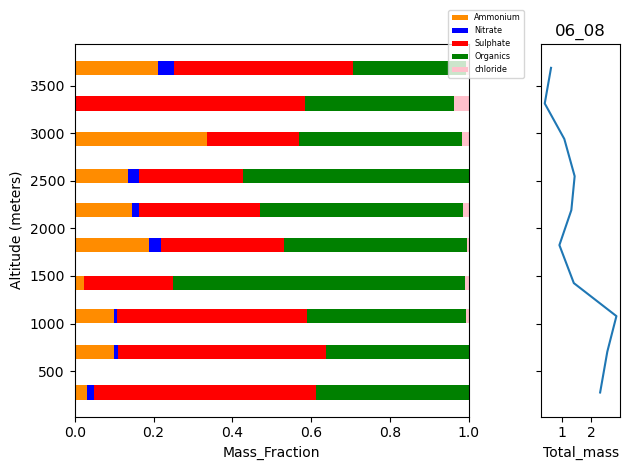

In [464]:
normal8 = (DAY8_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']+DAY8_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']+DAY8_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']+DAY8_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']+DAY8_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA'])
DAY8_subset_mean['AMS'] = normal8
DAY8_subset_mean = DAY8_subset_mean.sort_values(by= 'GPS_Altitude_THORNHILL')
y1 = DAY8_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA']/normal8
y2 = DAY8_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']/normal8
y3 = DAY8_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']/normal8
y4 = DAY8_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']/normal8
y5 = DAY8_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']/normal8
y6 = DAY8_subset_mean['mz44_Ave_IsoK_STP_ZIEMBA']/normal8
fig,ax = plt.subplots(1,2, width_ratios=[20, 4], sharey = "all")
ax[0].barh(DAY8_subset_mean['GPS_Altitude_THORNHILL'], y1, height = 150, color = "darkorange", label = 'Ammonium')
ax[0].barh(DAY8_subset_mean['GPS_Altitude_THORNHILL'], y2, left = y1, height = 150, color = "blue", label = 'Nitrate')
ax[0].barh(DAY8_subset_mean['GPS_Altitude_THORNHILL'], y3, left = y1+y2, height = 150, color = "red", label = 'Sulphate')
ax[0].barh(DAY8_subset_mean['GPS_Altitude_THORNHILL'], y4, left = y1+y2+y3, height = 150, color = "green", label = 'Organics')
#ax.barh(DAY8_subset_mean['GPS_Altitude_THORNHILL'], y6, left = y1+y2+y3, height = 400, color = "palegreen", label = 'mz44')
ax[0].barh(DAY8_subset_mean['GPS_Altitude_THORNHILL'], y5, left = y1+y2+y3+y4, height = 150, color = "pink", label = 'chloride')
ax[1].plot(normal8, DAY8_subset_mean['GPS_Altitude_THORNHILL'], label = 'Total_mass')

ax[0].set_ylabel('Altitude (meters)')
ax[0].set_xlabel('Mass_Fraction')
ax[1].set_xlabel('Total_mass')
ax[0].set_xlim(0,1)
plt.title('06_08')

ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')
plt.tight_layout()

In [465]:
DAY10 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220610_R0_L1_20230614T111636.ict')
start_index = np.where(DAY10["Time_Start"]==pd.to_datetime("2022-06-10 15:17:00"))
stop_index = np.where(DAY10["Time_Start"]==pd.to_datetime("2022-06-10 15:25:00"))
    
DAY10_subset = DAY10[start_index[0][0]:stop_index[0][0]]
DAY10_subset = DAY10_subset.replace(-888888, 0)
DAY10_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
10616,2022-06-10 15:17:00,2022-06-10 15:17:01,32.206691,-64.996969,122.040,0.311,0.857,0.124,-0.052,-0.006,-0.023
10617,2022-06-10 15:17:01,2022-06-10 15:17:02,32.207809,-64.997169,122.105,0.311,0.857,0.124,-0.052,-0.006,-0.023
10618,2022-06-10 15:17:02,2022-06-10 15:17:03,32.208928,-64.997370,122.170,0.311,0.857,0.124,-0.052,-0.006,-0.023
10619,2022-06-10 15:17:03,2022-06-10 15:17:04,32.210048,-64.997569,122.240,0.311,0.857,0.124,-0.052,-0.006,-0.023
10620,2022-06-10 15:17:04,2022-06-10 15:17:05,32.211167,-64.997768,122.315,0.311,0.857,0.124,-0.052,-0.006,-0.023
...,...,...,...,...,...,...,...,...,...,...,...
11091,2022-06-10 15:24:55,2022-06-10 15:24:56,32.207088,-65.031191,3540.260,0.243,0.189,0.017,-0.335,-0.018,0.027
11092,2022-06-10 15:24:56,2022-06-10 15:24:57,32.207061,-65.029663,3546.970,0.243,0.189,0.017,-0.335,-0.018,0.027
11093,2022-06-10 15:24:57,2022-06-10 15:24:58,32.207068,-65.028134,3553.620,0.243,0.189,0.017,-0.335,-0.018,0.027
11094,2022-06-10 15:24:58,2022-06-10 15:24:59,32.207109,-65.026603,3560.200,0.243,0.189,0.017,-0.335,-0.018,0.027


In [466]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY10_subset.GPS_Altitude_THORNHILL.min(), DAY10_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY10_subset['Bins'] = pd.cut(DAY10_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY10_subset_1000 = DAY10_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_10 = DAY10_subset_1000[start_index:stop_index]
DAY1000_subset_10.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,24,24,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,2022-06-10 15:18:37.479166720,2022-06-10 15:18:38.479166720,32.289081,-65.050463,534.617324,0.378214,1.124800,0.010600,0.272345,-0.003523,0.024393
min,2022-06-10 15:17:25,2022-06-10 15:17:26,32.234724,-65.101786,124.887449,0.292000,0.887776,-0.036000,0.013102,-0.013000,-0.015306
25%,2022-06-10 15:18:15.375000064,2022-06-10 15:18:16.375000064,32.284812,-65.078581,340.319687,0.309667,1.039000,-0.015000,0.198000,-0.009000,-0.007000
50%,2022-06-10 15:18:39.249999872,2022-06-10 15:18:40.249999872,32.293738,-65.048833,536.140000,0.334000,1.123000,0.024000,0.306000,-0.007583,0.014000
75%,2022-06-10 15:19:02.500000,2022-06-10 15:19:03.500000,32.299473,-65.021756,730.602812,0.397000,1.148000,0.027500,0.308000,0.004000,0.051000
max,2022-06-10 15:19:25.500000,2022-06-10 15:19:26.500000,32.301621,-65.001980,930.682500,0.826000,1.560000,0.064816,0.490000,0.014122,0.093000
std,NaN,NaN,0.015246,0.032410,243.092100,0.128824,0.132560,0.024102,0.090605,0.008330,0.030678


In [467]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY10_subset_3000 = DAY10_subset_1000[start_index:stop_index]
DAY10_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,72,72,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,2022-06-10 15:22:02.215277824,2022-06-10 15:22:03.215277568,32.251439,-65.054574,2223.082150,0.498595,0.650756,0.026150,0.156290,-0.007275,0.074615
min,2022-06-10 15:19:33.500000,2022-06-10 15:19:34.500000,32.210307,-65.111207,1001.980000,0.112000,0.202000,-0.036000,-0.175000,-0.039000,0.013000
25%,2022-06-10 15:20:44.375000064,2022-06-10 15:20:45.375000064,32.222557,-65.087411,1611.434250,0.302750,0.279750,0.005500,0.009900,-0.030000,0.024000
50%,2022-06-10 15:21:59.500000,2022-06-10 15:22:00.500000,32.247506,-65.062042,2224.210000,0.471000,0.435000,0.035000,0.178000,-0.001000,0.084000
75%,2022-06-10 15:23:18.124999936,2022-06-10 15:23:19.124999936,32.276805,-65.017379,2834.650250,0.776000,1.155000,0.043125,0.339000,0.008125,0.115000
max,2022-06-10 15:24:42.500000,2022-06-10 15:24:43.500000,32.302508,-64.988930,3448.995000,0.861000,1.560000,0.067000,0.490000,0.034000,0.128000
std,NaN,NaN,0.030859,0.040500,721.007276,0.238282,0.440849,0.028954,0.200801,0.021214,0.040976


In [468]:
nbins = 10
bins10 = np.linspace(DAY10_subset.GPS_Altitude_THORNHILL.min(), DAY10_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY10_subset['Bins'] = pd.cut(DAY10_subset['GPS_Altitude_THORNHILL'], bins10)
DAY10_subset_mean = DAY10_subset.groupby('Bins').mean()
DAY10_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(122.04, 466.509]",2022-06-10 15:17:45.500,2022-06-10 15:17:46.500000000,32.256412,-65.009692,205.705000,0.316222,0.991556,0.043222,0.144000,0.004111,-0.009222
"(466.509, 810.978]",2022-06-10 15:18:51.000,2022-06-10 15:18:52.000000000,32.299716,-65.063853,634.627927,0.366268,1.082024,0.004976,0.251659,-0.002659,0.032951
"(810.978, 1155.447]",2022-06-10 15:19:31.000,2022-06-10 15:19:32.000000000,32.277402,-65.103720,979.658846,0.727897,1.452205,-0.021564,0.417718,0.005462,0.084205
"(1155.447, 1499.916]",2022-06-10 15:20:10.500,2022-06-10 15:20:11.500000000,32.236081,-65.102113,1326.291500,0.837625,1.252150,0.000200,0.316325,-0.001775,0.127450
"(1499.916, 1844.385]",2022-06-10 15:20:51.500,2022-06-10 15:20:52.500000000,32.213377,-65.056119,1670.304048,0.542167,0.950738,0.042119,0.349405,-0.024119,0.086571
"(1844.385, 2188.854]",2022-06-10 15:21:34.000,2022-06-10 15:21:35.000000000,32.233316,-65.003295,2023.057209,0.430395,0.600209,0.014465,0.178558,-0.032442,0.069907
"(2188.854, 2533.323]",2022-06-10 15:22:16.500,2022-06-10 15:22:17.500000000,32.279634,-64.997803,2363.169286,0.303714,0.369429,0.033286,0.129429,0.014000,0.016429
"(2533.323, 2877.792]",2022-06-10 15:23:00.500,2022-06-10 15:23:01.500000256,32.299165,-65.046415,2703.850217,0.552261,0.351000,0.015565,0.040609,0.013087,0.089261
"(2877.792, 3222.261]",2022-06-10 15:23:48.000,2022-06-10 15:23:49.000000000,32.263147,-65.085278,3042.873061,0.348653,0.244837,0.052265,-0.058592,-0.024163,0.064857


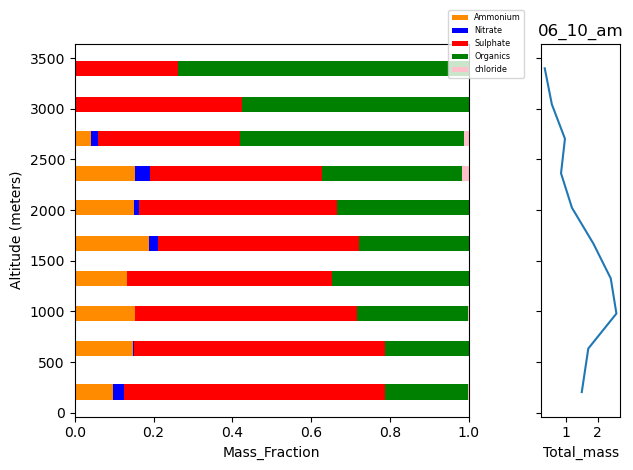

In [469]:
normal10 = (DAY10_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']+DAY10_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']+DAY10_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']+DAY10_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']+DAY10_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA'])
DAY10_subset_mean['AMS'] = normal10
DAY10_subset_mean = DAY10_subset_mean.sort_values(by= 'GPS_Altitude_THORNHILL')
y1 = DAY10_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA']/normal10
y2 = DAY10_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']/normal10
y3 = DAY10_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']/normal10
y4 = DAY10_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']/normal10
y5 = DAY10_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']/normal10
y6 = DAY10_subset_mean['mz44_Ave_IsoK_STP_ZIEMBA']/normal10
fig,ax = plt.subplots(1,2, width_ratios=[20, 4], sharey = "all")
ax[0].barh(DAY10_subset_mean['GPS_Altitude_THORNHILL'], y1, height = 150, color = "darkorange", label = 'Ammonium')
ax[0].barh(DAY10_subset_mean['GPS_Altitude_THORNHILL'], y2, left = y1, height = 150, color = "blue", label = 'Nitrate')
ax[0].barh(DAY10_subset_mean['GPS_Altitude_THORNHILL'], y3, left = y1+y2, height = 150, color = "red", label = 'Sulphate')
ax[0].barh(DAY10_subset_mean['GPS_Altitude_THORNHILL'], y4, left = y1+y2+y3, height = 150, color = "green", label = 'Organics')
#ax.barh(DAY10_subset_mean['GPS_Altitude_THORNHILL'], y6, left = y1+y2+y3, height = 400, color = "palegreen", label = 'mz44')
ax[0].barh(DAY10_subset_mean['GPS_Altitude_THORNHILL'], y5, left = y1+y2+y3+y4, height = 150, color = "pink", label = 'chloride')
ax[1].plot(normal10, DAY10_subset_mean['GPS_Altitude_THORNHILL'], label = 'Total_mass')

ax[0].set_ylabel('Altitude (meters)')
ax[0].set_xlabel('Mass_Fraction')
ax[1].set_xlabel('Total_mass')
ax[0].set_xlim(0,1)
plt.title('06_10_am')

ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')
plt.tight_layout()

In [470]:
DAY10b = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220610_R0_L2_20230614T111636.ict')
start_index = np.where(DAY10b["Time_Start"]==pd.to_datetime("2022-06-10 19:30:00"))
stop_index = np.where(DAY10b["Time_Start"]==pd.to_datetime("2022-06-10 20:45:00"))
    
DAY10b_subset = DAY10b[start_index[0][0]:stop_index[0][0]]
DAY10b_subset = DAY10b_subset.replace(-888888, 0)
DAY10b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
7182,2022-06-10 19:30:00,2022-06-10 19:30:01,31.639092,-65.606420,113.375,0.248,1.358,0.034,0.269,-0.004,0.026
7183,2022-06-10 19:30:01,2022-06-10 19:30:02,31.639446,-65.607515,113.225,0.248,1.358,0.034,0.269,-0.004,0.026
7184,2022-06-10 19:30:02,2022-06-10 19:30:03,31.639806,-65.608607,113.065,0.248,1.358,0.034,0.269,-0.004,0.026
7185,2022-06-10 19:30:03,2022-06-10 19:30:04,31.640170,-65.609698,112.970,0.248,1.358,0.034,0.269,-0.004,0.026
7186,2022-06-10 19:30:04,2022-06-10 19:30:05,31.640539,-65.610788,112.985,0.248,1.358,0.034,0.269,-0.004,0.026
...,...,...,...,...,...,...,...,...,...,...,...
11677,2022-06-10 20:44:55,2022-06-10 20:44:56,32.077748,-64.914861,1636.660,0.569,0.863,0.009,0.570,0.041,0.124
11678,2022-06-10 20:44:56,2022-06-10 20:44:57,32.078715,-64.913869,1630.380,0.569,0.863,0.009,0.570,0.041,0.124
11679,2022-06-10 20:44:57,2022-06-10 20:44:58,32.079681,-64.912880,1624.290,0.569,0.863,0.009,0.570,0.041,0.124
11680,2022-06-10 20:44:58,2022-06-10 20:44:59,32.080646,-64.911895,1618.170,0.569,0.863,0.009,0.570,0.041,0.124


In [471]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY10b_subset.GPS_Altitude_THORNHILL.min(), DAY10b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY10b_subset['Bins'] = pd.cut(DAY10b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY10b_subset_1000 = DAY10b_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_10b = DAY10b_subset_1000[start_index:stop_index]
DAY1000_subset_10b.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,17,17,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,2022-06-10 20:03:04.738654720,2022-06-10 20:03:05.738654976,31.463548,-65.877027,520.807188,0.293732,1.252258,0.032734,0.482619,0.005523,0.012749
min,2022-06-10 19:58:13.842105088,2022-06-10 19:58:14.842105088,31.257228,-65.912192,121.109551,0.163750,1.102850,-0.001789,0.346276,-0.014000,-0.036500
25%,2022-06-10 19:59:45.619047680,2022-06-10 19:59:46.619047424,31.385854,-65.884437,325.297857,0.236278,1.247444,0.026727,0.422650,-0.004476,0.007000
50%,2022-06-10 20:00:48.157894656,2022-06-10 20:00:49.157894912,31.488493,-65.882240,521.287778,0.278526,1.268286,0.033333,0.493316,0.001903,0.023500
75%,2022-06-10 20:05:36.318181632,2022-06-10 20:05:37.318181888,31.552241,-65.867219,718.324474,0.367650,1.291408,0.047571,0.527333,0.019350,0.028097
max,2022-06-10 20:16:01.414414592,2022-06-10 20:16:02.414414336,31.594506,-65.822952,912.233750,0.453613,1.341667,0.056524,0.615250,0.035677,0.043312
std,NaN,NaN,0.100813,0.020141,247.735459,0.094657,0.073373,0.017473,0.085190,0.014321,0.026330


In [472]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY10b_subset_3000 = DAY10b_subset_1000[start_index:stop_index]
DAY10b_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,50,50,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,2022-06-10 20:07:34.749670400,2022-06-10 20:07:35.749670400,31.508025,-65.767047,2207.934501,0.497673,0.705098,0.036178,0.236924,0.000774,0.075104
min,2022-06-10 19:56:57.444444416,2022-06-10 19:56:58.444444672,31.218992,-65.949112,1011.126667,0.207150,0.136714,-0.008000,-0.006200,-0.072841,-0.019400
25%,2022-06-10 20:04:50.338949632,2022-06-10 20:04:51.338949632,31.404345,-65.877020,1611.398305,0.370798,0.356735,0.020832,0.103124,-0.020152,0.051083
50%,2022-06-10 20:08:06.340952320,2022-06-10 20:08:07.340952576,31.556393,-65.744984,2206.686000,0.469155,0.694013,0.036576,0.211620,-0.002319,0.073190
75%,2022-06-10 20:10:48.834542848,2022-06-10 20:10:49.834542848,31.596532,-65.692428,2809.107242,0.606028,1.075667,0.048180,0.381492,0.021707,0.096679
max,2022-06-10 20:15:26.571428608,2022-06-10 20:15:27.571428608,31.716792,-65.539598,3409.206667,0.857409,1.233947,0.083698,0.498931,0.056381,0.171864
std,NaN,NaN,0.144690,0.106499,712.474631,0.172432,0.368000,0.021756,0.151296,0.028680,0.045127


In [473]:
nbins = 10
bins10b = np.linspace(DAY10b_subset.GPS_Altitude_THORNHILL.min(), DAY10b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY10b_subset['Bins'] = pd.cut(DAY10b_subset['GPS_Altitude_THORNHILL'], bins10b)
DAY10b_subset_mean = DAY10b_subset.groupby('Bins').mean()
DAY10b_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(105.665, 594.57]",2022-06-10 20:00:39.907242752,2022-06-10 20:00:40.907242496,31.422848,-65.842416,202.612128,0.321908,1.289622,0.032637,0.376420,0.005120,0.024269
"(594.57, 1083.476]",2022-06-10 20:06:19.662020864,2022-06-10 20:06:20.662021120,31.433620,-65.886171,757.808554,0.319024,1.169030,0.032072,0.470627,0.013663,0.020054
"(1083.476, 1572.382]",2022-06-10 20:07:21.857142784,2022-06-10 20:07:22.857142784,31.328995,-65.910732,1283.150745,0.483108,1.139026,0.030039,0.434463,0.021706,0.058026
"(1572.382, 2061.287]",2022-06-10 20:11:16.310096128,2022-06-10 20:11:17.310096384,31.428894,-65.792657,1846.201755,0.409170,0.984391,0.049374,0.361332,0.014698,0.078464
"(2061.287, 2550.192]",2022-06-10 20:08:56.530373888,2022-06-10 20:08:57.530373888,31.400047,-65.811963,2399.496799,0.710815,0.600912,0.059127,0.160383,-0.002964,0.118860
"(2550.192, 3039.098]",2022-06-10 20:06:41.742919424,2022-06-10 20:06:42.742919424,31.398991,-65.817120,2798.681176,0.601035,0.382669,0.035041,0.101184,-0.005344,0.106743
"(3039.098, 3528.004]",2022-06-10 20:06:22.852861184,2022-06-10 20:06:23.852860928,31.400937,-65.782078,3222.354523,0.285760,0.199234,0.012526,0.066500,-0.043968,0.009484
"(3528.004, 4016.909]",2022-06-10 20:08:35.678082048,2022-06-10 20:08:36.678082304,31.429713,-65.769617,3721.637466,0.215638,0.123793,0.005892,0.032142,-0.017750,0.010323
"(4016.909, 4505.814]",2022-06-10 20:11:14.798816512,2022-06-10 20:11:15.798816512,31.402682,-65.756761,4276.497663,0.261737,0.114212,-0.003320,0.074435,-0.004957,0.009356


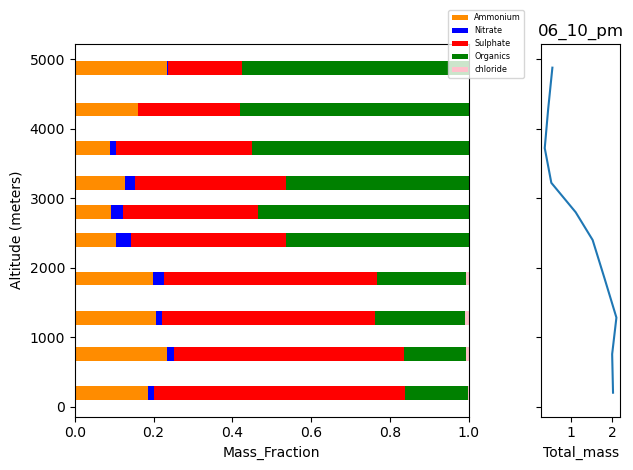

In [474]:
normal10b = (DAY10b_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']+DAY10b_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']+DAY10b_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']+DAY10b_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']+DAY10b_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA'])
DAY10b_subset_mean['AMS'] = normal8
DAY10b_subset_mean = DAY10b_subset_mean.sort_values(by= 'GPS_Altitude_THORNHILL')
y1 = DAY10b_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA']/normal10b
y2 = DAY10b_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']/normal10b
y3 = DAY10b_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']/normal10b
y4 = DAY10b_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']/normal10b
y5 = DAY10b_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']/normal10b
y6 = DAY10b_subset_mean['mz44_Ave_IsoK_STP_ZIEMBA']/normal10b
fig,ax = plt.subplots(1,2, width_ratios=[20, 4], sharey = "all")
ax[0].barh(DAY10b_subset_mean['GPS_Altitude_THORNHILL'], y1, height = 200, color = "darkorange", label = 'Ammonium')
ax[0].barh(DAY10b_subset_mean['GPS_Altitude_THORNHILL'], y2, left = y1, height = 200, color = "blue", label = 'Nitrate')
ax[0].barh(DAY10b_subset_mean['GPS_Altitude_THORNHILL'], y3, left = y1+y2, height = 200, color = "red", label = 'Sulphate')
ax[0].barh(DAY10b_subset_mean['GPS_Altitude_THORNHILL'], y4, left = y1+y2+y3, height = 200, color = "green", label = 'Organics')
#ax.barh(DAY10b_subset_mean['GPS_Altitude_THORNHILL'], y6, left = y1+y2+y3, height = 400, color = "palegreen", label = 'mz44')
ax[0].barh(DAY10b_subset_mean['GPS_Altitude_THORNHILL'], y5, left = y1+y2+y3+y4, height = 200, color = "pink", label = 'chloride')
ax[1].plot(normal10b, DAY10b_subset_mean['GPS_Altitude_THORNHILL'], label = 'Total_mass')

ax[0].set_ylabel('Altitude (meters)')
ax[0].set_xlabel('Mass_Fraction')
ax[1].set_xlabel('Total_mass')
ax[0].set_xlim(0,1)
plt.title('06_10_pm')

ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')
plt.tight_layout()

In [475]:
DAY11 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220611_R0_L1_20230614T111637.ict')
start_index = np.where(DAY11["Time_Start"]==pd.to_datetime("2022-06-11 15:24:00"))
stop_index = np.where(DAY11["Time_Start"]==pd.to_datetime("2022-06-11 15:42:00"))
    
DAY11_subset = DAY11[start_index[0][0]:stop_index[0][0]]
DAY11_subset = DAY11_subset.replace(-888888, 0)
DAY11_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
10800,2022-06-11 15:24:00,2022-06-11 15:24:01,32.234864,-64.977277,137.985,0.426,1.496,0.042,0.350,-0.004,-0.003
10801,2022-06-11 15:24:01,2022-06-11 15:24:02,32.233969,-64.976649,138.245,0.426,1.496,0.042,0.350,-0.004,-0.003
10802,2022-06-11 15:24:02,2022-06-11 15:24:03,32.233058,-64.976063,138.485,0.426,1.496,0.042,0.350,-0.004,-0.003
10803,2022-06-11 15:24:03,2022-06-11 15:24:04,32.232130,-64.975521,138.740,0.426,1.496,0.042,0.350,-0.004,-0.003
10804,2022-06-11 15:24:04,2022-06-11 15:24:05,32.231186,-64.975026,139.035,0.426,1.496,0.042,0.350,-0.004,-0.003
...,...,...,...,...,...,...,...,...,...,...,...
11875,2022-06-11 15:41:55,2022-06-11 15:41:56,32.259305,-64.971567,4701.700,0.580,0.154,-0.023,0.363,0.017,0.006
11876,2022-06-11 15:41:56,2022-06-11 15:41:57,32.258543,-64.970428,4708.440,0.580,0.154,-0.023,0.363,0.017,0.006
11877,2022-06-11 15:41:57,2022-06-11 15:41:58,32.257745,-64.969326,4714.800,0.580,0.154,-0.023,0.363,0.017,0.006
11878,2022-06-11 15:41:58,2022-06-11 15:41:59,32.256913,-64.968261,4720.960,0.580,0.154,-0.023,0.363,0.017,0.006


In [476]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY11_subset.GPS_Altitude_THORNHILL.min(), DAY11_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY11_subset['Bins'] = pd.cut(DAY11_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY11_subset_1000 = DAY11_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_11 = DAY11_subset_1000[start_index:stop_index]
DAY1000_subset_11.describe()


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,18,18,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000
mean,2022-06-11 15:27:20.118326272,2022-06-11 15:27:21.118325760,32.220720,-65.007791,548.346459,0.275848,0.852107,0.005138,0.251248,-0.000054,-0.011053
min,2022-06-11 15:24:38.129870080,2022-06-11 15:24:39.129870080,32.197496,-65.036850,141.553312,0.047000,0.575200,-0.058000,0.100000,-0.015000,-0.041091
25%,2022-06-11 15:26:32.375000064,2022-06-11 15:26:33.375000064,32.203415,-65.029359,355.942229,0.119063,0.654071,-0.028850,0.191000,-0.009288,-0.022013
50%,2022-06-11 15:27:35,2022-06-11 15:27:36,32.217243,-65.012114,551.257875,0.237731,0.691950,0.011500,0.256017,-0.007000,-0.014000
75%,2022-06-11 15:28:16,2022-06-11 15:28:17,32.237348,-64.988460,748.522619,0.490000,1.079708,0.029224,0.325932,0.004861,-0.008000
max,2022-06-11 15:29:05,2022-06-11 15:29:06,32.252484,-64.971716,932.450333,0.497000,1.462026,0.100533,0.369000,0.043867,0.038000
std,NaN,NaN,0.019598,0.022669,246.508119,0.176960,0.273721,0.045128,0.088837,0.017152,0.018378


In [477]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY11_subset_3000 = DAY11_subset_1000[start_index:stop_index]
DAY11_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,53,53,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000
mean,2022-06-11 15:34:51.264150784,2022-06-11 15:34:52.264151040,32.238715,-64.995622,2225.360581,0.213176,0.398190,-0.003329,0.157909,0.001084,0.006248
min,2022-06-11 15:29:30.500000,2022-06-11 15:29:31.500000,32.200188,-65.044243,1035.389286,-0.050000,0.144000,-0.076000,-0.245000,-0.052000,-0.048000
25%,2022-06-11 15:32:17,2022-06-11 15:32:18,32.217349,-65.018397,1625.907778,0.117231,0.189000,-0.011000,0.056333,-0.007273,-0.022000
50%,2022-06-11 15:35:29,2022-06-11 15:35:30,32.237558,-64.994723,2225.388889,0.260000,0.429800,-0.000500,0.193000,0.001000,0.017000
75%,2022-06-11 15:37:29,2022-06-11 15:37:30,32.261265,-64.974320,2823.684000,0.322000,0.532000,0.018800,0.280429,0.012769,0.028000
max,2022-06-11 15:38:57.500000,2022-06-11 15:38:58.500000,32.285639,-64.950412,3416.133333,0.358000,0.775000,0.052000,0.521000,0.044652,0.050000
std,NaN,NaN,0.024757,0.027528,708.226527,0.123889,0.190357,0.032836,0.175808,0.018952,0.030271


In [478]:
nbins = 10
bins11 = np.linspace(DAY11_subset.GPS_Altitude_THORNHILL.min(), DAY11_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY11_subset['Bins'] = pd.cut(DAY11_subset['GPS_Altitude_THORNHILL'], bins11)
DAY11_subset_mean = DAY11_subset.groupby('Bins').mean()
DAY11_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(137.295, 596.256]",2022-06-11 15:25:52.702222336,2022-06-11 15:25:53.702222080,32.219438,-64.998848,286.423489,0.236738,1.168484,0.002262,0.296320,-0.001827,-0.003009
"(596.256, 1055.218]",2022-06-11 15:28:41.500000000,2022-06-11 15:28:42.500000000,32.228795,-65.015158,845.452321,0.327036,0.597509,0.035223,0.254473,0.009402,-0.016375
"(1055.218, 1514.18]",2022-06-11 15:30:37.500000000,2022-06-11 15:30:38.500000000,32.220438,-64.995039,1269.931250,0.261717,0.621417,-0.010383,0.218608,-0.002083,-0.001917
"(1514.18, 1973.141]",2022-06-11 15:32:49.500000000,2022-06-11 15:32:50.500000000,32.241553,-65.007040,1736.124514,0.089313,0.548854,-0.014188,0.143146,0.010063,-0.018729
"(1973.141, 2432.102]",2022-06-11 15:35:07.500000000,2022-06-11 15:35:08.500000000,32.265972,-65.002925,2173.202045,0.246364,0.459159,0.010682,0.275318,0.013091,0.013659
"(2432.102, 2891.064]",2022-06-11 15:36:55.000000000,2022-06-11 15:36:56.000000000,32.212340,-64.973233,2642.450723,0.206554,0.216157,-0.003410,-0.101337,0.006446,-0.015940
"(2891.064, 3350.026]",2022-06-11 15:38:13.000000000,2022-06-11 15:38:14.000000000,32.248050,-65.008491,3126.077671,0.207973,0.192918,0.012233,0.156096,-0.005096,0.039521
"(3350.026, 3808.987]",2022-06-11 15:39:21.000000000,2022-06-11 15:39:22.000000000,32.237354,-64.956286,3577.126190,0.448889,0.209444,-0.050460,0.313921,-0.009794,0.008238
"(3808.987, 4267.948]",2022-06-11 15:40:21.000000256,2022-06-11 15:40:22.000000000,32.208927,-65.006624,4039.932632,0.384912,0.197632,-0.000368,0.054439,0.009070,0.009491


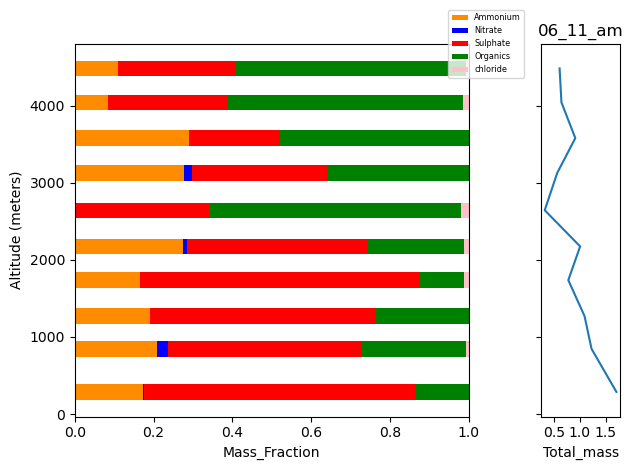

In [479]:
normal11 = (DAY11_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']+DAY11_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']+DAY11_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']+DAY11_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']+DAY11_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA'])
DAY11_subset_mean['AMS'] = normal11
DAY11_subset_mean = DAY11_subset_mean.sort_values(by= 'GPS_Altitude_THORNHILL')
y1 = DAY11_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA']/normal11
y2 = DAY11_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']/normal11
y3 = DAY11_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']/normal11
y4 = DAY11_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']/normal11
y5 = DAY11_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']/normal11
y6 = DAY11_subset_mean['mz44_Ave_IsoK_STP_ZIEMBA']/normal11
fig,ax = plt.subplots(1,2, width_ratios=[20, 4], sharey = "all")
ax[0].barh(DAY11_subset_mean['GPS_Altitude_THORNHILL'], y1, height = 200, color = "darkorange", label = 'Ammonium')
ax[0].barh(DAY11_subset_mean['GPS_Altitude_THORNHILL'], y2, left = y1, height = 200, color = "blue", label = 'Nitrate')
ax[0].barh(DAY11_subset_mean['GPS_Altitude_THORNHILL'], y3, left = y1+y2, height = 200, color = "red", label = 'Sulphate')
ax[0].barh(DAY11_subset_mean['GPS_Altitude_THORNHILL'], y4, left = y1+y2+y3, height = 200, color = "green", label = 'Organics')
#ax.barh(DAY11_subset_mean['GPS_Altitude_THORNHILL'], y6, left = y1+y2+y3, height = 400, color = "palegreen", label = 'mz44')
ax[0].barh(DAY11_subset_mean['GPS_Altitude_THORNHILL'], y5, left = y1+y2+y3+y4, height = 200, color = "pink", label = 'chloride')
ax[1].plot(normal11, DAY11_subset_mean['GPS_Altitude_THORNHILL'], label = 'Total_mass')

ax[0].set_ylabel('Altitude (meters)')
ax[0].set_xlabel('Mass_Fraction')
ax[0].set_xlim(0,1)
ax[1].set_xlabel('Total_mass')
plt.title('06_11_am')

ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')
plt.tight_layout()

In [480]:
DAY11b = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220611_R0_L2_20230614T111637.ict')
start_index = np.where(DAY11b["Time_Start"]==pd.to_datetime("2022-06-11 20:00:00"))
stop_index = np.where(DAY11b["Time_Start"]==pd.to_datetime("2022-06-11 20:30:00"))
    
DAY11b_subset = DAY11b[start_index[0][0]:stop_index[0][0]]
DAY11b_subset = DAY11b_subset.replace(-888888, 0)
DAY11b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
9350,2022-06-11 20:00:00,2022-06-11 20:00:01,30.851085,-64.222657,132.360,0.393,1.633,0.020,0.140,0.016,0.003
9351,2022-06-11 20:00:01,2022-06-11 20:00:02,30.851840,-64.221712,132.715,0.393,1.633,0.020,0.140,0.016,0.003
9352,2022-06-11 20:00:02,2022-06-11 20:00:03,30.852625,-64.220800,133.040,0.393,1.633,0.020,0.140,0.016,0.003
9353,2022-06-11 20:00:03,2022-06-11 20:00:04,30.853437,-64.219921,133.300,0.393,1.633,0.020,0.140,0.016,0.003
9354,2022-06-11 20:00:04,2022-06-11 20:00:05,30.854278,-64.219077,133.540,0.393,1.633,0.020,0.140,0.016,0.003
...,...,...,...,...,...,...,...,...,...,...,...
11145,2022-06-11 20:29:55,2022-06-11 20:29:56,31.260152,-64.521769,3323.730,0.449,0.322,0.002,0.176,0.003,0.022
11146,2022-06-11 20:29:56,2022-06-11 20:29:57,31.261412,-64.522059,3325.020,0.300,0.233,-0.055,0.148,0.018,-0.016
11147,2022-06-11 20:29:57,2022-06-11 20:29:58,31.262673,-64.522348,3326.270,0.300,0.233,-0.055,0.148,0.018,-0.016
11148,2022-06-11 20:29:58,2022-06-11 20:29:59,31.263934,-64.522638,3327.430,0.300,0.233,-0.055,0.148,0.018,-0.016


In [481]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY11b_subset.GPS_Altitude_THORNHILL.min(), DAY11b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY11b_subset['Bins'] = pd.cut(DAY11b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY11b_subset_1000 = DAY11b_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_11b = DAY11b_subset_1000[start_index:stop_index]
DAY1000_subset_11b.describe()


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,27,27,27.000000,27.000000,27.000000,27.000000,27.000000,27.00000,27.000000,27.000000,27.000000
mean,2022-06-11 20:09:03.148596224,2022-06-11 20:09:04.148596224,31.236134,-64.669717,543.585200,0.405463,0.951367,0.00755,0.274603,0.013530,0.039548
min,2022-06-11 20:04:07.512096768,2022-06-11 20:04:08.512096768,31.035566,-64.702104,123.488034,0.070000,0.847000,-0.03300,-0.024000,-0.004000,0.000000
25%,2022-06-11 20:08:41,2022-06-11 20:08:42,31.225826,-64.694864,335.922292,0.298571,0.893000,-0.01800,0.096090,0.011000,0.018000
50%,2022-06-11 20:09:13.000000256,2022-06-11 20:09:14,31.243701,-64.676702,542.633333,0.416000,0.956000,0.02900,0.356000,0.013000,0.028000
75%,2022-06-11 20:09:43.250000128,2022-06-11 20:09:44.249999872,31.257823,-64.663295,752.587917,0.501000,0.977500,0.03100,0.396000,0.015000,0.066000
max,2022-06-11 20:10:12.500000,2022-06-11 20:10:13.500000,31.265189,-64.424176,961.682500,0.549000,1.472770,0.05500,0.510000,0.026000,0.081000
std,NaN,NaN,0.043048,0.051781,254.903128,0.134641,0.120778,0.03044,0.196327,0.007511,0.030054


In [482]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY11b_subset_3000 = DAY11b_subset_1000[start_index:stop_index]
DAY11b_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,71,71,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000
mean,2022-06-11 20:15:58.620866304,2022-06-11 20:15:59.620865792,31.209246,-64.635844,2153.911019,0.180829,0.462630,-0.002176,0.125793,0.008685,-0.000120
min,2022-06-11 20:10:22.999999744,2022-06-11 20:10:24,31.036776,-64.709010,1025.980000,-0.081000,0.288833,-0.077000,-0.084583,-0.016692,-0.026083
25%,2022-06-11 20:11:28.500000,2022-06-11 20:11:29.500000,31.191639,-64.681765,1592.523750,0.138684,0.317438,-0.013724,0.042125,-0.009000,-0.017000
50%,2022-06-11 20:17:05.423077120,2022-06-11 20:17:06.423077120,31.221921,-64.652320,2152.079803,0.219000,0.401609,0.003000,0.082333,0.007792,0.000000
75%,2022-06-11 20:19:01.308628480,2022-06-11 20:19:02.308628480,31.245810,-64.606449,2716.507323,0.257625,0.542000,0.015310,0.235000,0.012892,0.007000
max,2022-06-11 20:29:18,2022-06-11 20:29:19,31.274808,-64.393900,3281.890000,0.418667,0.927333,0.036347,0.426000,0.064000,0.064000
std,NaN,NaN,0.055110,0.066829,664.411108,0.125263,0.179810,0.022503,0.112147,0.021882,0.018937


In [483]:
nbins = 10
bins11b = np.linspace(DAY11b_subset.GPS_Altitude_THORNHILL.min(), DAY11b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY11b_subset['Bins'] = pd.cut(DAY11b_subset['GPS_Altitude_THORNHILL'], bins11b)
DAY11b_subset_men = DAY11b_subset.groupby('Bins').mean()
DAY11b_subset_men

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(108.925, 430.876]",2022-06-11 20:04:25.578947584,2022-06-11 20:04:26.578947328,31.048383,-64.441558,134.588148,0.437370,1.438282,0.036043,0.203776,0.003504,0.029669
"(430.876, 752.828]",2022-06-11 20:09:18.000000256,2022-06-11 20:09:19.000000256,31.254113,-64.692607,581.287353,0.384961,0.878333,-0.021745,0.364627,0.014098,0.031275
"(752.828, 1074.78]",2022-06-11 20:10:06.000000000,2022-06-11 20:10:07.000000000,31.244982,-64.658812,913.888333,0.484222,0.953778,0.015000,0.447778,0.019111,0.060111
"(1074.78, 1396.731]",2022-06-11 20:10:46.500000000,2022-06-11 20:10:47.500000000,31.225202,-64.687149,1242.020833,0.190111,0.736333,0.007167,0.270222,-0.004167,-0.017556
"(1396.731, 1718.683]",2022-06-11 20:11:24.000000000,2022-06-11 20:11:25.000000000,31.255199,-64.704345,1561.362564,-0.027154,0.597718,0.011179,0.179718,0.036821,-0.009744
"(1718.683, 2040.634]",2022-06-11 20:12:05.000000000,2022-06-11 20:12:06.000000000,31.267573,-64.666544,1875.074419,0.148256,0.505605,0.013488,0.180721,0.006000,0.018326
"(2040.634, 2362.586]",2022-06-11 20:21:51.601809920,2022-06-11 20:21:52.601809920,31.110252,-64.472493,2193.151146,0.228872,0.398507,-0.000874,0.105155,0.010255,0.005437
"(2362.586, 2684.537]",2022-06-11 20:17:41.503649536,2022-06-11 20:17:42.503649792,31.161868,-64.650925,2500.270803,0.255949,0.318445,-0.018496,0.046161,0.012584,0.003956
"(2684.537, 3006.489]",2022-06-11 20:19:00.454545408,2022-06-11 20:19:01.454545408,31.204214,-64.615311,2838.500682,0.259720,0.307598,-0.011424,0.052242,0.006333,-0.009871


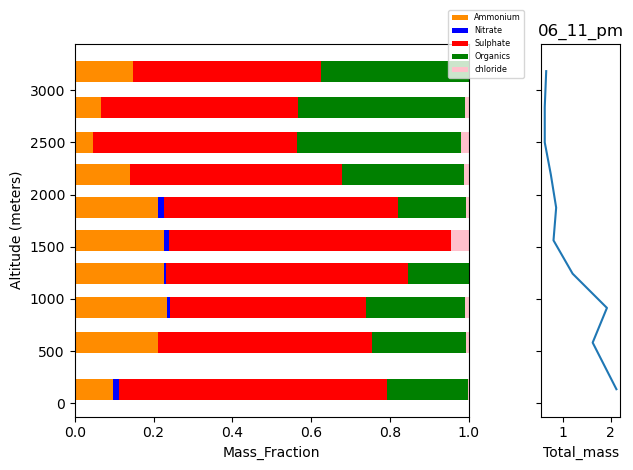

In [484]:
normal11b = (DAY11b_subset_men['Chl_Ave_IsoK_STP_ZIEMBA']+DAY11b_subset_men['Org_Ave_IsoK_STP_ZIEMBA']+DAY11b_subset_men['SO4_Ave_IsoK_STP_ZIEMBA']+DAY11b_subset_men['NO3_Ave_IsoK_STP_ZIEMBA']+DAY11b_subset_men['NH4_Ave_IsoK_STP_ZIEMBA'])
DAY11b_subset_men['AMS'] = normal11b
DAY11b_subset_men = DAY11b_subset_men.sort_values(by= 'GPS_Altitude_THORNHILL')
y1 = DAY11b_subset_men['NH4_Ave_IsoK_STP_ZIEMBA']/normal11b
y2 = DAY11b_subset_men['NO3_Ave_IsoK_STP_ZIEMBA']/normal11b
y3 = DAY11b_subset_men['SO4_Ave_IsoK_STP_ZIEMBA']/normal11b
y4 = DAY11b_subset_men['Org_Ave_IsoK_STP_ZIEMBA']/normal11b
y5 = DAY11b_subset_men['Chl_Ave_IsoK_STP_ZIEMBA']/normal11b
y6 = DAY11b_subset_men['mz44_Ave_IsoK_STP_ZIEMBA']/normal11b
fig,ax = plt.subplots(1,2, width_ratios=[20, 4], sharey = "all")
ax[0].barh(DAY11b_subset_men['GPS_Altitude_THORNHILL'], y1, height = 200, color = "darkorange", label = 'Ammonium')
ax[0].barh(DAY11b_subset_men['GPS_Altitude_THORNHILL'], y2, left = y1, height = 200, color = "blue", label = 'Nitrate')
ax[0].barh(DAY11b_subset_men['GPS_Altitude_THORNHILL'], y3, left = y1+y2, height = 200, color = "red", label = 'Sulphate')
ax[0].barh(DAY11b_subset_men['GPS_Altitude_THORNHILL'], y4, left = y1+y2+y3, height = 200, color = "green", label = 'Organics')
#ax.barh(DAY11b_subset_men['GPS_Altitude_THORNHILL'], y6, left = y1+y2+y3, height = 400, color = "palegreen", label = 'mz44')
ax[0].barh(DAY11b_subset_men['GPS_Altitude_THORNHILL'], y5, left = y1+y2+y3+y4, height = 200, color = "pink", label = 'chloride')
ax[1].plot(normal11b, DAY11b_subset_men['GPS_Altitude_THORNHILL'], label = 'Total_mass')

ax[0].set_ylabel('Altitude (meters)')
ax[0].set_xlabel('Mass_Fraction')
ax[1].set_xlabel('Total_mass')
ax[0].set_xlim(0,1)
plt.title('06_11_pm')

ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')
plt.tight_layout()

In [485]:
DAY13 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220613_R0_L1_20230614T111637.ict')
start_index = np.where(DAY13["Time_Start"]==pd.to_datetime("2022-06-13 14:30:00"))
stop_index = np.where(DAY13["Time_Start"]==pd.to_datetime("2022-06-13 14:46:00"))
    
DAY13_subset = DAY13[start_index[0][0]:stop_index[0][0]]
DAY13_subset = DAY13_subset.replace(-888888, 0)
DAY13_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
10015,2022-06-13 14:30:00,2022-06-13 14:30:01,32.210354,-65.054053,141.795,0.207,0.760,-0.037,0.166,0.031,-0.012
10016,2022-06-13 14:30:01,2022-06-13 14:30:02,32.209934,-65.052981,141.725,0.207,0.760,-0.037,0.166,0.031,-0.012
10017,2022-06-13 14:30:02,2022-06-13 14:30:03,32.209541,-65.051894,141.615,0.207,0.760,-0.037,0.166,0.031,-0.012
10018,2022-06-13 14:30:03,2022-06-13 14:30:04,32.209173,-65.050793,141.460,0.207,0.760,-0.037,0.166,0.031,-0.012
10019,2022-06-13 14:30:04,2022-06-13 14:30:05,32.208832,-65.049680,141.275,0.207,0.760,-0.037,0.166,0.031,-0.012
...,...,...,...,...,...,...,...,...,...,...,...
10970,2022-06-13 14:45:55,2022-06-13 14:45:56,32.197220,-65.046274,4504.770,0.472,0.218,0.043,0.118,0.027,0.009
10971,2022-06-13 14:45:56,2022-06-13 14:45:57,32.196954,-65.044914,4514.670,0.472,0.218,0.043,0.118,0.027,0.009
10972,2022-06-13 14:45:57,2022-06-13 14:45:58,32.196726,-65.043543,4523.980,0.472,0.218,0.043,0.118,0.027,0.009
10973,2022-06-13 14:45:58,2022-06-13 14:45:59,32.196539,-65.042160,4532.940,0.472,0.218,0.043,0.118,0.027,0.009


In [486]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY13_subset.GPS_Altitude_THORNHILL.min(), DAY13_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY13_subset['Bins'] = pd.cut(DAY13_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY13_subset_1000 = DAY13_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_13 = DAY13_subset_1000[start_index:stop_index]
DAY1000_subset_13.describe()


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,19,19,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,2022-06-13 14:32:44.694736896,2022-06-13 14:32:45.694736896,32.244420,-65.051465,556.049107,0.270172,0.808265,0.025146,0.172765,-0.009805,-0.011944
min,2022-06-13 14:30:32.200000,2022-06-13 14:30:33.200000,32.197392,-65.097735,142.037308,0.070000,0.575000,-0.039923,-0.107000,-0.047000,-0.086000
25%,2022-06-13 14:31:54.500000,2022-06-13 14:31:55.500000,32.212486,-65.083628,359.240333,0.202700,0.701548,-0.009000,0.113750,-0.026000,-0.036182
50%,2022-06-13 14:32:45.500000,2022-06-13 14:32:46.500000,32.245854,-65.051067,556.630833,0.248364,0.849000,0.031083,0.157429,-0.003091,-0.015083
75%,2022-06-13 14:33:39.249999872,2022-06-13 14:33:40.249999872,32.275700,-65.020351,756.111250,0.298000,0.916100,0.053955,0.276462,0.001000,0.011875
max,2022-06-13 14:34:30.500000,2022-06-13 14:34:31.500000,32.287260,-64.994298,954.156429,0.580000,0.955000,0.077000,0.325000,0.035308,0.061000
std,NaN,NaN,0.033910,0.035095,249.917479,0.136871,0.132430,0.038893,0.135137,0.022014,0.040461


In [487]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY13_subset_3000 = DAY13_subset_1000[start_index:stop_index]
DAY13_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,55,55,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,2022-06-13 14:40:30.081818112,2022-06-13 14:40:31.081818368,32.253689,-65.017370,2230.044937,0.156716,0.373154,0.000758,0.113514,0.013087,-0.031428
min,2022-06-13 14:34:55.500000,2022-06-13 14:34:56.500000,32.197171,-65.094145,1042.884167,-0.054000,0.273000,-0.049000,-0.119000,-0.013000,-0.133000
25%,2022-06-13 14:38:08.249999872,2022-06-13 14:38:09.249999872,32.226733,-65.048756,1636.347917,0.048000,0.303550,-0.021000,0.016000,0.008000,-0.058000
50%,2022-06-13 14:41:17.500000,2022-06-13 14:41:18.500000,32.256386,-65.004790,2228.825000,0.105333,0.338333,-0.008000,0.099929,0.009000,-0.024000
75%,2022-06-13 14:42:58.249999872,2022-06-13 14:42:59.249999872,32.281042,-64.986767,2825.135000,0.253800,0.421567,0.025000,0.211058,0.018000,-0.002500
max,2022-06-13 14:44:01,2022-06-13 14:44:02,32.293834,-64.972350,3419.562000,0.655000,0.601000,0.099000,0.332000,0.056000,0.046000
std,NaN,NaN,0.029446,0.037474,705.259840,0.150657,0.094575,0.028587,0.126319,0.013986,0.036863


In [488]:
nbins = 10
bins13 = np.linspace(DAY13_subset.GPS_Altitude_THORNHILL.min(), DAY13_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY13_subset['Bins'] = pd.cut(DAY13_subset['GPS_Altitude_THORNHILL'], bins13)
DAY13_subset_mean = DAY13_subset.groupby('Bins').mean()
DAY13_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(138.195, 578.542]",2022-06-13 14:31:25.695906304,2022-06-13 14:31:26.695906304,32.251602,-65.029198,287.809064,0.192310,0.780620,0.007415,0.119485,0.013620,-0.014129
"(578.542, 1018.888]",2022-06-13 14:33:50.500000000,2022-06-13 14:33:51.500000000,32.217537,-65.063852,799.163898,0.315407,0.854034,0.024644,0.248814,-0.024797,-0.009576
"(1018.888, 1459.234]",2022-06-13 14:35:59.000000000,2022-06-13 14:36:00.000000000,32.268210,-65.026384,1245.222302,0.153518,0.537201,0.003324,0.188007,0.002295,-0.007094
"(1459.234, 1899.581]",2022-06-13 14:38:21.500000000,2022-06-13 14:38:22.500000000,32.218896,-65.040238,1673.850342,0.293644,0.413781,0.023521,0.171192,0.012986,-0.003973
"(1899.581, 2339.928]",2022-06-13 14:40:39.000000000,2022-06-13 14:40:40.000000000,32.276015,-65.032278,2097.121008,0.130907,0.342721,-0.004543,0.043953,0.012186,-0.048643
"(2339.928, 2780.274]",2022-06-13 14:42:18.500000000,2022-06-13 14:42:19.500000000,32.226927,-65.023434,2512.975286,0.226114,0.331171,-0.016686,0.030314,0.037143,-0.031629
"(2780.274, 3220.62]",2022-06-13 14:43:17.000000000,2022-06-13 14:43:18.000000000,32.263635,-64.977333,2998.251277,0.052213,0.303511,-0.016213,0.148936,0.008532,-0.069234
"(3220.62, 3660.967]",2022-06-13 14:44:04.000000000,2022-06-13 14:44:05.000000000,32.286216,-65.020226,3446.552553,0.090383,0.281149,0.009447,0.066596,0.005681,-0.013872
"(3660.967, 4101.314]",2022-06-13 14:44:51.500000000,2022-06-13 14:44:52.500000000,32.255467,-65.066155,3880.000000,0.064917,0.308250,0.007625,0.299625,-0.011125,-0.052583


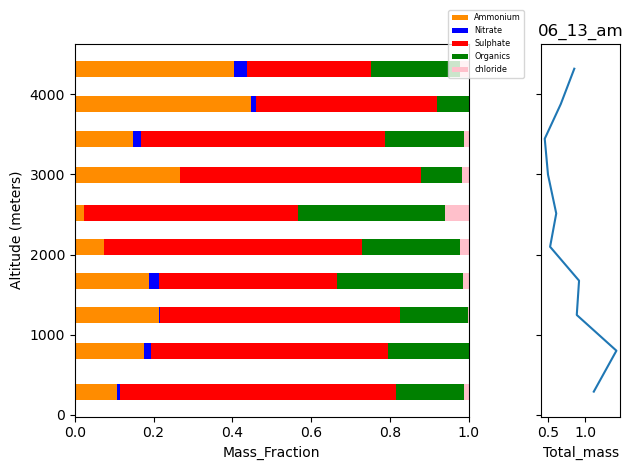

In [489]:
normal13 = (DAY13_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']+DAY13_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']+DAY13_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']+DAY13_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']+DAY13_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA'])
DAY13_subset_mean['AMS'] = normal13
DAY13_subset_mean = DAY13_subset_mean.sort_values(by= 'GPS_Altitude_THORNHILL')
y1 = DAY13_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA']/normal13
y2 = DAY13_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']/normal13
y3 = DAY13_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']/normal13
y4 = DAY13_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']/normal13
y5 = DAY13_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']/normal13
y6 = DAY13_subset_mean['mz44_Ave_IsoK_STP_ZIEMBA']/normal13
fig,ax = plt.subplots(1,2, width_ratios=[20, 4], sharey = "all")
ax[0].barh(DAY13_subset_mean['GPS_Altitude_THORNHILL'], y1, height = 200, color = "darkorange", label = 'Ammonium')
ax[0].barh(DAY13_subset_mean['GPS_Altitude_THORNHILL'], y2, left = y1, height = 200, color = "blue", label = 'Nitrate')
ax[0].barh(DAY13_subset_mean['GPS_Altitude_THORNHILL'], y3, left = y1+y2, height = 200, color = "red", label = 'Sulphate')
ax[0].barh(DAY13_subset_mean['GPS_Altitude_THORNHILL'], y4, left = y1+y2+y3, height = 200, color = "green", label = 'Organics')
#ax.barh(DAY13b_subset_mean['GPS_Altitude_THORNHILL'], y6, left = y1+y2+y3, height = 400, color = "palegreen", label = 'mz44')
ax[0].barh(DAY13_subset_mean['GPS_Altitude_THORNHILL'], y5, left = y1+y2+y3+y4, height = 200, color = "pink", label = 'chloride')
ax[1].plot(normal13, DAY13_subset_mean['GPS_Altitude_THORNHILL'], label = 'Total_mass')

ax[0].set_ylabel('Altitude (meters)')
ax[0].set_xlabel('Mass_Fraction')
ax[0].set_xlim(0,1)
ax[1].set_xlabel('Total_mass')
plt.title('06_13_am')

ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')
plt.tight_layout()

In [490]:
DAY13b = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220613_R0_L2_20230614T111637.ict')
start_index = np.where(DAY13b["Time_Start"]==pd.to_datetime("2022-06-13 19:46:00"))
stop_index = np.where(DAY13b["Time_Start"]==pd.to_datetime("2022-06-13 20:09:00")) 
DAY13b_subset = DAY13b[start_index[0][0]:stop_index[0][0]]
DAY13b_subset = DAY13b_subset.replace(-888888, 0)
DAY13b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
10610,2022-06-13 19:46:00,2022-06-13 19:46:01,32.251226,-65.007304,106.13,0.122,0.732,0.079,0.011,-0.010,-0.036
10611,2022-06-13 19:46:01,2022-06-13 19:46:02,32.250414,-65.006555,105.59,0.122,0.732,0.079,0.011,-0.010,-0.036
10612,2022-06-13 19:46:02,2022-06-13 19:46:03,32.249605,-65.005808,106.45,0.122,0.732,0.079,0.011,-0.010,-0.036
10613,2022-06-13 19:46:03,2022-06-13 19:46:04,32.248799,-65.005062,108.91,0.122,0.732,0.079,0.011,-0.010,-0.036
10614,2022-06-13 19:46:04,2022-06-13 19:46:05,32.247996,-65.004323,112.60,0.122,0.732,0.079,0.011,-0.010,-0.036
...,...,...,...,...,...,...,...,...,...,...,...
11985,2022-06-13 20:08:55,2022-06-13 20:08:56,32.290180,-64.996666,4558.09,0.299,0.259,-0.013,-0.186,0.032,0.055
11986,2022-06-13 20:08:56,2022-06-13 20:08:57,32.289203,-64.997413,4565.53,0.299,0.259,-0.013,-0.186,0.032,0.055
11987,2022-06-13 20:08:57,2022-06-13 20:08:58,32.288204,-64.998124,4572.98,0.299,0.259,-0.013,-0.186,0.032,0.055
11988,2022-06-13 20:08:58,2022-06-13 20:08:59,32.287185,-64.998799,4580.36,0.098,0.231,0.133,0.113,-0.036,0.018


In [491]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY13b_subset.GPS_Altitude_THORNHILL.min(), DAY13b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY13b_subset['Bins'] = pd.cut(DAY13b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY13b_subset_1000 = DAY13b_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_13b = DAY13b_subset_1000[start_index:stop_index]
DAY1000_subset_13b.describe()


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,19,19,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,2022-06-13 19:48:39.235588864,2022-06-13 19:48:40.235589120,32.251283,-64.963002,531.245099,0.112804,0.485443,-0.017075,0.064697,0.012694,-0.012211
min,2022-06-13 19:46:21.476190464,2022-06-13 19:46:22.476190464,32.223206,-65.001759,121.140833,-0.046800,0.380000,-0.057000,-0.142000,-0.020000,-0.093000
25%,2022-06-13 19:47:40.500000,2022-06-13 19:47:41.500000,32.232798,-64.988673,329.961447,0.012560,0.424000,-0.044000,-0.021000,0.001000,-0.034700
50%,2022-06-13 19:48:37,2022-06-13 19:48:38,32.250778,-64.959460,534.096316,0.122000,0.462000,-0.025000,0.057000,0.021941,-0.007000
75%,2022-06-13 19:49:41.249999872,2022-06-13 19:49:42.249999872,32.270597,-64.938746,733.858157,0.171500,0.565000,-0.001000,0.144000,0.028231,0.017912
max,2022-06-13 19:50:47,2022-06-13 19:50:48,32.284827,-64.927901,932.806818,0.340000,0.695357,0.065881,0.320000,0.033000,0.049000
std,NaN,NaN,0.021802,0.026008,252.706341,0.113510,0.088584,0.034324,0.132975,0.018475,0.042518


In [492]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY13b_subset_3000 = DAY13b_subset_1000[start_index:stop_index]
DAY13b_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,55,55,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,2022-06-13 20:00:15.181818368,2022-06-13 20:00:16.181818112,32.258703,-64.985245,2234.138114,0.142626,0.363119,0.008990,0.040932,0.006086,-0.028059
min,2022-06-13 19:51:08.500000,2022-06-13 19:51:09.500000,32.213525,-65.041886,1023.430000,-0.130000,0.204000,-0.061861,-0.170000,-0.043477,-0.121000
25%,2022-06-13 19:55:19,2022-06-13 19:55:20,32.234643,-65.005720,1627.179611,0.083167,0.267000,-0.013370,-0.051545,-0.004889,-0.047000
50%,2022-06-13 20:01:55.500000,2022-06-13 20:01:56.500000,32.262861,-64.985925,2236.028333,0.141000,0.296000,0.013000,0.069538,0.000000,-0.027000
75%,2022-06-13 20:05:10,2022-06-13 20:05:11,32.282607,-64.966122,2838.776270,0.211346,0.400000,0.021000,0.112000,0.018357,-0.011500
max,2022-06-13 20:06:36,2022-06-13 20:06:37,32.293438,-64.930466,3445.874000,0.442000,0.692000,0.086000,0.259000,0.053000,0.038000
std,NaN,NaN,0.025029,0.027589,718.104350,0.118570,0.136915,0.030818,0.109318,0.017133,0.034882


In [493]:
nbins = 10
bins13b = np.linspace(DAY13b_subset.GPS_Altitude_THORNHILL.min(), DAY13b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY13b_subset['Bins'] = pd.cut(DAY13b_subset['GPS_Altitude_THORNHILL'], bins13)
DAY13b_subset_mean = DAY13b_subset.groupby('Bins').mean()
DAY13b_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(138.195, 578.542]",2022-06-13 19:47:48.000,2022-06-13 19:47:49.000000000,32.258422,-64.952551,363.200851,0.062319,0.511879,-0.007908,0.040957,0.001213,-0.029872
"(578.542, 1018.888]",2022-06-13 19:50:03.000,2022-06-13 19:50:04.000000000,32.245452,-64.968583,800.856822,0.169256,0.456775,-0.031605,0.120589,0.024984,0.010326
"(1018.888, 1459.234]",2022-06-13 19:52:17.500,2022-06-13 19:52:18.500000000,32.265466,-64.999528,1267.317929,0.111829,0.610893,0.020321,0.070293,0.025936,-0.007307
"(1459.234, 1899.581]",2022-06-13 19:56:02.500,2022-06-13 19:56:03.500000000,32.254047,-64.987997,1690.909935,0.125919,0.336723,-0.005832,0.157868,-0.011210,-0.023006
"(1899.581, 2339.928]",2022-06-13 20:00:32.500,2022-06-13 20:00:33.500000000,32.266872,-64.987326,2080.553304,0.164226,0.255252,-0.000487,0.053748,0.004687,-0.026700
"(2339.928, 2780.274]",2022-06-13 20:03:43.000,2022-06-13 20:03:44.000000000,32.245894,-64.967257,2565.530596,0.113457,0.290272,0.032404,-0.092172,0.014457,-0.030199
"(2780.274, 3220.62]",2022-06-13 20:05:33.500,2022-06-13 20:05:34.500000000,32.266075,-64.993830,2990.786857,0.141829,0.287486,0.002957,0.018529,-0.002100,-0.035743
"(3220.62, 3660.967]",2022-06-13 20:06:34.500,2022-06-13 20:06:35.499999744,32.224856,-64.964075,3438.893462,0.335077,0.349385,-0.005500,0.011654,0.002962,-0.006577
"(3660.967, 4101.314]",2022-06-13 20:07:26.000,2022-06-13 20:07:27.000000000,32.259428,-64.919134,3884.520588,0.466471,0.337980,0.002412,0.290392,0.013000,0.031294


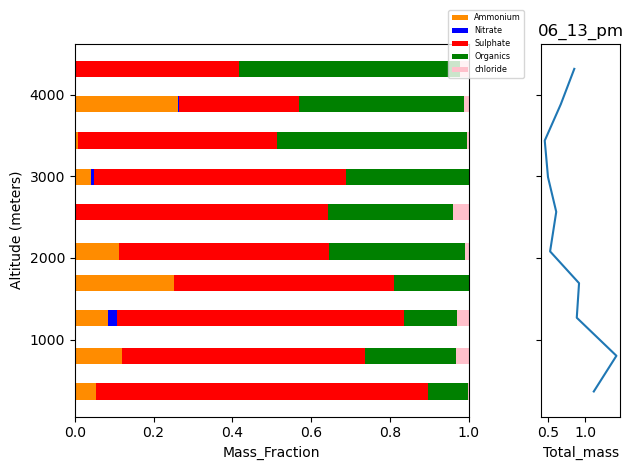

In [494]:
normal13b = (DAY13b_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']+DAY13b_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']+DAY13b_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']+DAY13b_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']+DAY13b_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA'])
DAY13b_subset_mean['AMS'] = normal13b
DAY13b_subset_mean = DAY13b_subset_mean.sort_values(by= 'GPS_Altitude_THORNHILL')
y1 = DAY13b_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA']/normal13b
y2 = DAY13b_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']/normal13b
y3 = DAY13b_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']/normal13b
y4 = DAY13b_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']/normal13b
y5 = DAY13b_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']/normal13b
y6 = DAY13b_subset_mean['mz44_Ave_IsoK_STP_ZIEMBA']/normal13b
fig,ax = plt.subplots(1,2, width_ratios=[20, 4], sharey = "all")
ax[0].barh(DAY13b_subset_mean['GPS_Altitude_THORNHILL'], y1, height = 200, color = "darkorange", label = 'Ammonium')
ax[0].barh(DAY13b_subset_mean['GPS_Altitude_THORNHILL'], y2, left = y1, height = 200, color = "blue", label = 'Nitrate')
ax[0].barh(DAY13b_subset_mean['GPS_Altitude_THORNHILL'], y3, left = y1+y2, height = 200, color = "red", label = 'Sulphate')
ax[0].barh(DAY13b_subset_mean['GPS_Altitude_THORNHILL'], y4, left = y1+y2+y3, height = 200, color = "green", label = 'Organics')
#ax.barh(DAY13b_subset_mean['GPS_Altitude_THORNHILL'], y6, left = y1+y2+y3, height = 400, color = "palegreen", label = 'mz44')
ax[0].barh(DAY13b_subset_mean['GPS_Altitude_THORNHILL'], y5, left = y1+y2+y3+y4, height = 200, color = "pink", label = 'chloride')
ax[1].plot(normal13, DAY13b_subset_mean['GPS_Altitude_THORNHILL'], label = 'Total_mass')

ax[0].set_ylabel('Altitude (meters)')
ax[0].set_xlabel('Mass_Fraction')
ax[0].set_xlim(0,1)
ax[1].set_xlabel('Total_mass')
plt.title('06_13_pm')

ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')
plt.tight_layout()

In [495]:
DAY14 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220614_R0_20230614T111638.ict')
start_index = np.where(DAY14["Time_Start"]==pd.to_datetime("2022-06-14 16:05:00"))
stop_index = np.where(DAY14["Time_Start"]==pd.to_datetime("2022-06-14 16:25:00"))
DAY14_subset = DAY14[start_index[0][0]:stop_index[0][0]]
DAY14_subset = DAY14_subset.replace(-888888, 0)
DAY14_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
9363,2022-06-14 16:05:00,2022-06-14 16:05:01,30.642555,-64.394685,117.000,0.419,0.764,0.052,0.223,0.006,0.024
9364,2022-06-14 16:05:01,2022-06-14 16:05:02,30.641725,-64.395343,117.085,0.419,0.764,0.052,0.223,0.006,0.024
9365,2022-06-14 16:05:02,2022-06-14 16:05:03,30.640923,-64.396042,117.190,0.419,0.764,0.052,0.223,0.006,0.024
9366,2022-06-14 16:05:03,2022-06-14 16:05:04,30.640148,-64.396780,117.295,0.238,0.747,0.077,-0.117,-0.008,0.020
9367,2022-06-14 16:05:04,2022-06-14 16:05:05,30.639403,-64.397555,117.380,0.238,0.747,0.077,-0.117,-0.008,0.020
...,...,...,...,...,...,...,...,...,...,...,...
10558,2022-06-14 16:24:55,2022-06-14 16:24:56,30.850057,-64.439182,8454.590,0.229,0.155,0.206,0.466,-0.023,-0.089
10559,2022-06-14 16:24:56,2022-06-14 16:24:57,30.851471,-64.439393,8461.000,0.229,0.155,0.206,0.466,-0.023,-0.089
10560,2022-06-14 16:24:57,2022-06-14 16:24:58,30.852885,-64.439595,8467.420,0.229,0.155,0.206,0.466,-0.023,-0.089
10561,2022-06-14 16:24:58,2022-06-14 16:24:59,30.854300,-64.439786,8473.860,0.229,0.155,0.206,0.466,-0.023,-0.089


In [496]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY14_subset.GPS_Altitude_THORNHILL.min(), DAY14_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY14_subset['Bins'] = pd.cut(DAY14_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY14_subset_1000 = DAY14_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_14 = DAY14_subset_1000[start_index:stop_index]
DAY1000_subset_14.describe()


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,10,10,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,2022-06-14 16:06:20.549999872,2022-06-14 16:06:21.549999872,30.665996,-64.421215,532.612161,0.151320,0.778640,0.007758,0.145120,0.018219,-0.024017
min,2022-06-14 16:05:20,2022-06-14 16:05:21,30.635158,-64.443667,129.846923,-0.133000,0.499000,-0.061000,-0.018333,-0.010000,-0.049000
25%,2022-06-14 16:05:57.624999936,2022-06-14 16:05:58.624999936,30.654523,-64.438572,347.133625,0.070583,0.701000,-0.011583,0.095250,-0.001231,-0.047000
50%,2022-06-14 16:06:21.750000128,2022-06-14 16:06:22.750000128,30.670587,-64.423276,535.254470,0.176600,0.805115,0.022100,0.172583,0.015000,-0.035817
75%,2022-06-14 16:06:46,2022-06-14 16:06:47,30.679871,-64.407655,723.516250,0.276667,0.840625,0.024000,0.228525,0.038875,-0.002000
max,2022-06-14 16:07:10.500000,2022-06-14 16:07:11.500000,30.684512,-64.387230,913.690000,0.428000,0.984000,0.054718,0.235000,0.055000,0.015128
std,NaN,NaN,0.017557,0.020702,258.194532,0.181349,0.150520,0.032035,0.101119,0.024588,0.026894


In [497]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY14_subset_3000 = DAY14_subset_1000[start_index:stop_index]
DAY14_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,28,28,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,2022-06-14 16:09:40.571428352,2022-06-14 16:09:41.571428864,30.665512,-64.406044,2207.918130,0.266287,0.208536,0.011087,0.009928,0.016691,0.006289
min,2022-06-14 16:07:29.500000,2022-06-14 16:07:30.500000,30.637684,-64.436561,1077.070000,-0.110000,0.091000,-0.043000,-0.283000,-0.014000,-0.054000
25%,2022-06-14 16:08:34.124999936,2022-06-14 16:08:35.124999936,30.644458,-64.425179,1642.586361,0.190850,0.148600,-0.017275,-0.066000,0.000000,-0.019000
50%,2022-06-14 16:09:38.750000128,2022-06-14 16:09:39.750000128,30.661879,-64.407742,2206.432056,0.274000,0.171000,0.014000,-0.016000,0.016000,0.013000
75%,2022-06-14 16:10:45.624999936,2022-06-14 16:10:46.624999936,30.684682,-64.388273,2773.432083,0.376500,0.252000,0.039000,0.092000,0.031925,0.039000
max,2022-06-14 16:11:56,2022-06-14 16:11:57,30.699582,-64.368152,3338.431111,0.572000,0.461500,0.078000,0.272000,0.048000,0.050000
std,NaN,NaN,0.021283,0.022013,688.131611,0.193180,0.096754,0.034966,0.150640,0.018297,0.033700


In [498]:
nbins = 10
bins14 = np.linspace(DAY14_subset.GPS_Altitude_THORNHILL.min(), DAY14_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY14_subset['Bins'] = pd.cut(DAY14_subset['GPS_Altitude_THORNHILL'], bins14)
DAY14_subset_mean = DAY14_subset.groupby('Bins').mean()
DAY14_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(117.0, 953.333]",2022-06-14 16:06:08.000000000,2022-06-14 16:06:09.000000000,30.659707,-64.419702,449.283185,0.173385,0.783956,0.017867,0.111356,0.014259,-0.016044
"(953.333, 1789.666]",2022-06-14 16:08:03.500000000,2022-06-14 16:08:04.500000000,30.654197,-64.414863,1375.408281,0.454771,0.342229,-0.012562,0.002104,0.005917,0.029813
"(1789.666, 2625.999]",2022-06-14 16:09:40.000000000,2022-06-14 16:09:40.999999744,30.671456,-64.386691,2214.643608,0.116773,0.131515,0.004773,-0.092412,0.018113,-0.014134
"(2625.999, 3462.332]",2022-06-14 16:11:19.000000000,2022-06-14 16:11:20.000000000,30.672396,-64.412405,3038.086436,0.237327,0.178644,0.036782,0.108426,0.023941,0.006000
"(3462.332, 4298.665]",2022-06-14 16:13:08.499999744,2022-06-14 16:13:09.500000000,30.659536,-64.388819,3904.438390,0.216246,0.166576,0.018136,-0.029339,0.007678,0.008966
"(4298.665, 5134.998]",2022-06-14 16:15:22.000000000,2022-06-14 16:15:23.000000000,30.671316,-64.376391,4717.452752,0.331483,0.095376,0.010879,-0.137846,-0.012597,0.012221
"(5134.998, 5971.331]",2022-06-14 16:17:35.000000000,2022-06-14 16:17:35.999999744,30.689983,-64.382142,5540.587863,0.086641,0.103658,0.005376,-0.007786,-0.001214,0.007282
"(5971.331, 6807.664]",2022-06-14 16:19:28.500000000,2022-06-14 16:19:29.500000000,30.661610,-64.384839,6378.099091,0.354036,0.106091,-0.013600,0.024255,-0.000991,0.044182
"(6807.664, 7643.997]",2022-06-14 16:21:24.000000000,2022-06-14 16:21:25.000000000,30.681770,-64.355255,7271.420661,0.391860,0.098860,0.002537,0.122545,0.019967,0.016107


In [499]:
DAY14_subset_mean.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,10,10,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,2022-06-14 16:14:35.049999872,2022-06-14 16:14:36.049999872,30.677174,-64.394643,4294.355885,0.279006,0.216078,0.019470,0.028654,0.007352,0.009853
min,2022-06-14 16:06:08,2022-06-14 16:06:09,30.654197,-64.425318,449.283185,0.086641,0.095376,-0.013600,-0.137846,-0.012597,-0.016044
25%,2022-06-14 16:10:04.750000128,2022-06-14 16:10:05.749999872,30.660182,-64.414249,2420.504315,0.184100,0.104266,0.003096,-0.023951,-0.001158,0.004602
50%,2022-06-14 16:14:15.249999872,2022-06-14 16:14:16.249999872,30.671386,-64.387755,4310.945571,0.284405,0.142696,0.008128,0.013179,0.006797,0.008124
75%,2022-06-14 16:19:00.124999936,2022-06-14 16:19:01.124999936,30.679426,-64.382816,6168.721284,0.382404,0.175627,0.018068,0.110623,0.017150,0.015136
max,2022-06-14 16:23:42,2022-06-14 16:23:43,30.749767,-64.355255,8054.138581,0.454771,0.783956,0.124516,0.185239,0.023941,0.044182
std,NaN,NaN,0.027751,0.022428,2548.055083,0.130908,0.212476,0.039768,0.102378,0.011644,0.018020


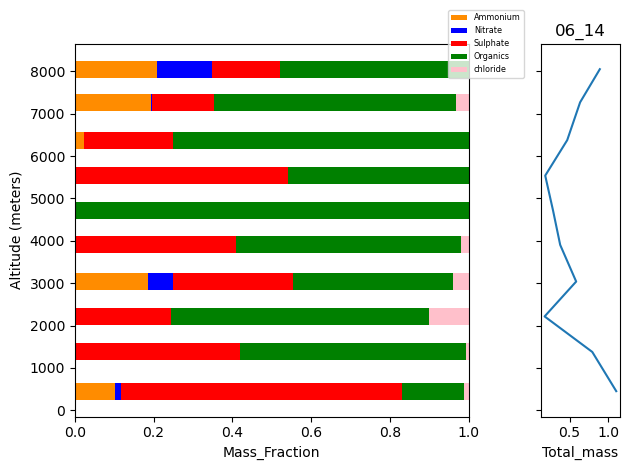

In [500]:
normal14 = (DAY14_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']+DAY14_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']+DAY14_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']+DAY14_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']+DAY14_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA'])
DAY14_subset_mean['AMS'] = normal14
DAY14_subset_mean = DAY14_subset_mean.sort_values(by= 'GPS_Altitude_THORNHILL')
y1 = DAY14_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA']/normal14
y2 = DAY14_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']/normal14
y3 = DAY14_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']/normal14
y4 = DAY14_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']/normal14
y5 = DAY14_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']/normal14
y6 = DAY14_subset_mean['mz44_Ave_IsoK_STP_ZIEMBA']/normal14
fig,ax = plt.subplots(1,2, width_ratios=[20, 4], sharey = "all")
ax[0].barh(DAY14_subset_mean['GPS_Altitude_THORNHILL'], y1, height = 400, color = "darkorange", label = 'Ammonium')
ax[0].barh(DAY14_subset_mean['GPS_Altitude_THORNHILL'], y2, left = y1, height = 400, color = "blue", label = 'Nitrate')
ax[0].barh(DAY14_subset_mean['GPS_Altitude_THORNHILL'], y3, left = y1+y2, height = 400, color = "red", label = 'Sulphate')
ax[0].barh(DAY14_subset_mean['GPS_Altitude_THORNHILL'], y4, left = y1+y2+y3, height = 400, color = "green", label = 'Organics')
#ax.barh(DAY14_subset_mean[' GPS_Altitude_THORNHILL'], y6, left = y1+y2+y3, height = 400, color = "palegreen", label = 'mz44')
ax[0].barh(DAY14_subset_mean['GPS_Altitude_THORNHILL'], y5, left = y1+y2+y3+y4, height = 400, color = "pink", label = 'chloride')
ax[1].plot(normal14, DAY14_subset_mean['GPS_Altitude_THORNHILL'], label = 'Total_mass')

ax[0].set_ylabel('Altitude (meters)')
ax[0].set_xlabel('Mass_Fraction')
ax[0].set_xlim(0,1)
ax[1].set_xlabel('Total_mass')
plt.title('06_14')

ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')
plt.tight_layout()

In [501]:
DAY17 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220617_R0_20230614T111638.ict')
start_index = np.where(DAY17["Time_Start"]==pd.to_datetime("2022-06-17 16:20:00"))
stop_index = np.where(DAY17["Time_Start"]==pd.to_datetime("2022-06-17 16:47:00")) 
DAY17_subset = DAY17[start_index[0][0]:stop_index[0][0]]
DAY17_subset = DAY17_subset.replace(-888888, 0)
DAY17_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
10469,2022-06-17 16:20:00,2022-06-17 16:20:01,32.206574,-65.006772,134.100,0.504,0.614,0.000,0.096,0.051,0.016
10470,2022-06-17 16:20:01,2022-06-17 16:20:02,32.206131,-65.005761,133.795,0.504,0.614,0.000,0.096,0.051,0.016
10471,2022-06-17 16:20:02,2022-06-17 16:20:03,32.205725,-65.004728,133.485,0.504,0.614,0.000,0.096,0.051,0.016
10472,2022-06-17 16:20:03,2022-06-17 16:20:04,32.205357,-65.003676,133.170,0.504,0.614,0.000,0.096,0.051,0.016
10473,2022-06-17 16:20:04,2022-06-17 16:20:05,32.205027,-65.002606,132.825,0.504,0.614,0.000,0.096,0.051,0.016
...,...,...,...,...,...,...,...,...,...,...,...
12084,2022-06-17 16:46:55,2022-06-17 16:46:56,32.158601,-65.020304,7639.050,0.540,0.148,-0.076,0.036,0.043,0.004
12085,2022-06-17 16:46:56,2022-06-17 16:46:57,32.157293,-65.019563,7645.810,0.540,0.148,-0.076,0.036,0.043,0.004
12086,2022-06-17 16:46:57,2022-06-17 16:46:58,32.156002,-65.018778,7652.610,0.540,0.148,-0.076,0.036,0.043,0.004
12087,2022-06-17 16:46:58,2022-06-17 16:46:59,32.154729,-65.017953,7659.440,0.540,0.148,-0.076,0.036,0.043,0.004


In [502]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY17_subset.GPS_Altitude_THORNHILL.min(), DAY17_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY17_subset['Bins'] = pd.cut(DAY17_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY17_subset_1000 = DAY17_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_17 = DAY17_subset_1000[start_index:stop_index]
DAY1000_subset_17.describe()


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,11,11,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,2022-06-17 16:22:51.845070592,2022-06-17 16:22:52.845070336,32.237853,-64.999281,537.166776,0.701616,0.739437,0.015330,0.269795,-0.000103,0.046027
min,2022-06-17 16:20:35.295774720,2022-06-17 16:20:36.295774720,32.213844,-65.043782,138.339507,0.242000,0.589000,-0.058000,-0.039000,-0.041304,-0.013000
25%,2022-06-17 16:22:01.500000,2022-06-17 16:22:02.500000,32.222402,-65.012799,351.893329,0.517331,0.642260,-0.009750,0.081214,-0.027500,0.022930
50%,2022-06-17 16:22:57,2022-06-17 16:22:58,32.239178,-64.995274,541.829286,0.616714,0.677043,0.031169,0.308380,-0.005870,0.043000
75%,2022-06-17 16:23:48.500000,2022-06-17 16:23:49.500000,32.252117,-64.979576,725.054302,0.875704,0.838130,0.047000,0.425826,0.021112,0.072472
max,2022-06-17 16:24:41.500000,2022-06-17 16:24:42.500000,32.263103,-64.968086,919.207250,1.201947,0.963300,0.064000,0.594000,0.053500,0.095000
std,NaN,NaN,0.016975,0.024119,253.912383,0.294046,0.129922,0.042301,0.210683,0.033592,0.034606


In [503]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY17_subset_3000 = DAY17_subset_1000[start_index:stop_index]
DAY17_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,32,32,32.000000,32.000000,32.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,2022-06-17 16:34:08.953124864,2022-06-17 16:34:09.953125120,32.214209,-65.013055,2235.716062,0.594771,0.532336,0.039145,0.225593,0.017460,0.038358
min,2022-06-17 16:25:25,2022-06-17 16:25:26,32.178844,-65.051537,1069.572000,0.187310,0.127000,-0.026000,0.002000,-0.032931,-0.049000
25%,2022-06-17 16:32:07.249999872,2022-06-17 16:32:08.250000128,32.191975,-65.038791,1649.697685,0.485550,0.185091,-0.009216,0.153912,-0.002222,0.025909
50%,2022-06-17 16:35:19.249999872,2022-06-17 16:35:20.249999872,32.210141,-65.014286,2234.973551,0.564875,0.268000,0.030156,0.241000,0.022333,0.038200
75%,2022-06-17 16:36:48,2022-06-17 16:36:49,32.238503,-64.988837,2819.493000,0.659596,0.631000,0.088333,0.302583,0.030477,0.050750
max,2022-06-17 16:38:08.500000,2022-06-17 16:38:09.500000,32.252481,-64.972554,3406.321000,1.058000,1.875333,0.118000,0.471000,0.065000,0.106000
std,NaN,NaN,0.024051,0.026619,707.975643,0.167592,0.549962,0.049621,0.129971,0.028583,0.034097


In [504]:
nbins = 10
bins17 = np.linspace(DAY17_subset.GPS_Altitude_THORNHILL.min(), DAY17_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY17_subset['Bins'] = pd.cut(DAY17_subset['GPS_Altitude_THORNHILL'], bins17)
DAY17_subset_mean = DAY17_subset.groupby('Bins').mean()
DAY17_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(124.73, 878.885]",2022-06-17 16:22:15.815497984,2022-06-17 16:22:16.815497984,32.234894,-64.992273,425.629668,0.649572,0.689498,0.017332,0.250210,0.001661,0.044786
"(878.885, 1633.04]",2022-06-17 16:28:16.000000000,2022-06-17 16:28:17.000000000,32.220790,-65.014841,1245.529454,0.672147,1.121767,0.010377,0.223233,0.012800,0.040140
"(1633.04, 2387.195]",2022-06-17 16:33:52.000000000,2022-06-17 16:33:53.000000000,32.219952,-65.007689,1960.842466,0.568192,0.591845,0.033083,0.271751,-0.011062,0.048425
"(2387.195, 3141.35]",2022-06-17 16:36:38.500000000,2022-06-17 16:36:39.499999744,32.218805,-65.029606,2756.544455,0.536636,0.192091,0.077773,0.195091,0.028591,0.033318
"(3141.35, 3895.505]",2022-06-17 16:38:20.000000000,2022-06-17 16:38:21.000000000,32.210228,-64.984610,3508.160430,0.788774,0.201118,0.038989,0.114570,0.044118,0.063495
"(3895.505, 4649.66]",2022-06-17 16:39:50.500000000,2022-06-17 16:39:51.500000000,32.200044,-65.029024,4280.062045,0.515386,0.129455,0.092045,0.209364,0.024068,0.028114
"(4649.66, 5403.815]",2022-06-17 16:41:15.500000000,2022-06-17 16:41:16.500000000,32.185069,-64.959899,5029.384512,0.165610,0.207805,0.088293,0.145659,0.006390,-0.012122
"(5403.815, 6157.97]",2022-06-17 16:42:40.000000000,2022-06-17 16:42:41.000000000,32.223073,-65.009439,5785.719310,1.301816,0.205954,0.147563,0.030736,-0.014207,0.202103
"(6157.97, 6912.125]",2022-06-17 16:44:13.499999744,2022-06-17 16:44:14.500000000,32.163536,-64.979062,6545.490900,2.123500,0.081150,0.153150,0.401150,0.021650,0.348700


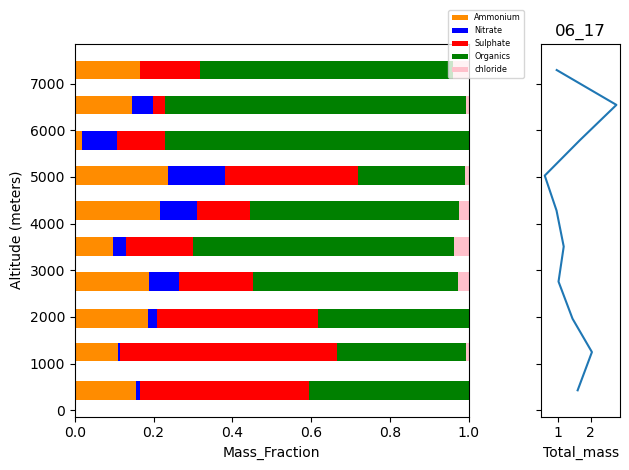

In [505]:
normal17 = (DAY17_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']+DAY17_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']+DAY17_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']+DAY17_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']+DAY17_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA'])
DAY17_subset_mean['AMS'] = normal17
DAY17_subset_mean = DAY17_subset_mean.sort_values(by= 'GPS_Altitude_THORNHILL')
y1 = DAY17_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA']/normal17
y2 = DAY17_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']/normal17
y3 = DAY17_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']/normal17
y4 = DAY17_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']/normal17
y5 = DAY17_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']/normal17
y6 = DAY17_subset_mean['mz44_Ave_IsoK_STP_ZIEMBA']/normal17
fig,ax = plt.subplots(1,2, width_ratios=[20, 4], sharey = "all")
ax[0].barh(DAY17_subset_mean['GPS_Altitude_THORNHILL'], y1, height = 400, color = "darkorange", label = 'Ammonium')
ax[0].barh(DAY17_subset_mean['GPS_Altitude_THORNHILL'], y2, left = y1, height = 400, color = "blue", label = 'Nitrate')
ax[0].barh(DAY17_subset_mean['GPS_Altitude_THORNHILL'], y3, left = y1+y2, height = 400, color = "red", label = 'Sulphate')
ax[0].barh(DAY17_subset_mean['GPS_Altitude_THORNHILL'], y4, left = y1+y2+y3, height = 400, color = "green", label = 'Organics')
#ax.barh(DAY17_subset_mean[' GPS_Altitude_THORNHILL'], y6, left = y1+y2+y3, height = 400, color = "palegreen", label = 'mz44')
ax[0].barh(DAY17_subset_mean['GPS_Altitude_THORNHILL'], y5, left = y1+y2+y3+y4, height = 400, color = "pink", label = 'chloride')
ax[1].plot(normal17, DAY17_subset_mean['GPS_Altitude_THORNHILL'], label = 'Total_mass')

ax[0].set_ylabel('Altitude (meters)')
ax[0].set_xlabel('Mass_Fraction')
ax[1].set_xlabel('Total_mass')
ax[0].set_xlim(0,1)
plt.title('06_17')

ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')
plt.tight_layout()

In [506]:
DAY18 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220618_R0_20230614T111638.ict')
start_index = np.where(DAY18["Time_Start"]==pd.to_datetime("2022-06-18 14:09:00"))
stop_index = np.where(DAY18["Time_Start"]==pd.to_datetime("2022-06-18 14:33:00"))    
DAY18_subset = DAY18[start_index[0][0]:stop_index[0][0]]
#DAY18_subset = DAY18_subset.replace(-888888, 0)
DAY18_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
7425,2022-06-18 14:09:00,2022-06-18 14:09:01,36.589500,-71.990803,110.135,4.910,1.114,0.234,0.181,0.013,0.556
7426,2022-06-18 14:09:01,2022-06-18 14:09:02,36.590250,-71.991516,110.155,4.910,1.114,0.234,0.181,0.013,0.556
7427,2022-06-18 14:09:02,2022-06-18 14:09:03,36.591026,-71.992186,109.965,4.910,1.114,0.234,0.181,0.013,0.556
7428,2022-06-18 14:09:03,2022-06-18 14:09:04,36.591824,-71.992808,109.535,4.910,1.114,0.234,0.181,0.013,0.556
7429,2022-06-18 14:09:04,2022-06-18 14:09:05,36.592643,-71.993383,109.055,4.910,1.114,0.234,0.181,0.013,0.556
...,...,...,...,...,...,...,...,...,...,...,...
8860,2022-06-18 14:32:55,2022-06-18 14:32:56,36.634224,-71.921855,7949.270,0.554,0.095,0.145,0.197,0.001,-0.019
8861,2022-06-18 14:32:56,2022-06-18 14:32:57,36.634412,-71.923239,7954.260,0.554,0.095,0.145,0.197,0.001,-0.019
8862,2022-06-18 14:32:57,2022-06-18 14:32:58,36.634602,-71.924625,7959.290,0.554,0.095,0.145,0.197,0.001,-0.019
8863,2022-06-18 14:32:58,2022-06-18 14:32:59,36.634793,-71.926012,7964.380,0.554,0.095,0.145,0.197,0.001,-0.019


In [507]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY18_subset.GPS_Altitude_THORNHILL.min(), DAY18_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY18_subset['Bins'] = pd.cut(DAY18_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY18_subset_1000 = DAY18_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY18_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY18_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_18 = DAY18_subset_1000[start_index:stop_index]
DAY1000_subset_18.describe()


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,10,10,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,2022-06-18 14:11:38.374137856,2022-06-18 14:11:39.374138112,36.608924,-72.004370,496.944384,5.453914,1.146725,0.233951,0.593170,0.004602,0.620773
min,2022-06-18 14:09:29.241379328,2022-06-18 14:09:30.241379328,36.566434,-72.047167,132.794655,4.788000,0.806000,0.148000,0.431957,-0.026143,0.521000
25%,2022-06-18 14:10:46.875000064,2022-06-18 14:10:47.875000064,36.586033,-72.034436,321.789448,5.265724,1.095345,0.214123,0.486012,-0.023304,0.568636
50%,2022-06-18 14:11:39.500000,2022-06-18 14:11:40.500000,36.608750,-72.005418,495.300240,5.508727,1.150478,0.236384,0.550197,0.006072,0.628695
75%,2022-06-18 14:12:33.500000,2022-06-18 14:12:34.500000,36.631835,-71.983900,680.431436,5.691983,1.213841,0.259593,0.606675,0.027150,0.675043
max,2022-06-18 14:13:32.999999744,2022-06-18 14:13:34.000000256,36.654091,-71.955549,852.631522,5.870609,1.360789,0.343000,1.067000,0.040667,0.698000
std,NaN,NaN,0.031193,0.033269,241.050369,0.360047,0.155313,0.055220,0.189373,0.028164,0.062988


In [508]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY18_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY18_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY18_subset_3000 = DAY18_subset_1000[start_index:stop_index]
DAY18_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,31,31,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
mean,2022-06-18 14:19:04.016129024,2022-06-18 14:19:05.016129024,36.583673,-71.978208,2189.291455,3.512008,0.815906,0.216833,0.378666,0.018265,0.412719
min,2022-06-18 14:14:13,2022-06-18 14:14:14,36.537275,-72.042481,1011.794412,0.945000,0.342000,0.058000,-0.118000,-0.016000,0.104000
25%,2022-06-18 14:16:57.750000128,2022-06-18 14:16:58.750000128,36.557218,-72.002256,1597.906511,1.522600,0.503000,0.085854,0.260966,0.009700,0.208611
50%,2022-06-18 14:19:49.500000,2022-06-18 14:19:50.500000,36.585047,-71.976110,2182.954000,2.417187,0.861471,0.146400,0.375652,0.018000,0.312000
75%,2022-06-18 14:21:12.249999872,2022-06-18 14:21:13.249999872,36.607052,-71.947094,2780.572278,5.550229,1.141473,0.341208,0.431500,0.030635,0.618937
max,2022-06-18 14:22:29,2022-06-18 14:22:30,36.620810,-71.926589,3371.061818,8.099000,1.221273,0.585000,0.890000,0.048000,0.893435
std,NaN,NaN,0.026860,0.035843,715.257157,2.314682,0.313673,0.157308,0.234088,0.017552,0.249953


In [509]:
nbins = 10
bins18 = np.linspace(DAY17_subset.GPS_Altitude_THORNHILL.min(), DAY18_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY18_subset['Bins'] = pd.cut(DAY18_subset['GPS_Altitude_THORNHILL'], bins18)
DAY18_subset_mean = DAY18_subset.groupby('Bins').mean()
DAY18_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(124.73, 909.207]",2022-06-18 14:11:41.000000000,2022-06-18 14:11:42.000000000,36.610183,-72.001091,503.228996,5.452282,1.138263,0.238320,0.603046,0.003015,0.618402
"(909.207, 1693.684]",2022-06-18 14:15:36.000000000,2022-06-18 14:15:36.999999744,36.581877,-71.988693,1300.652796,4.755891,1.101204,0.260512,0.478578,0.021114,0.545578
"(1693.684, 2478.161]",2022-06-18 14:18:57.500000000,2022-06-18 14:18:58.500000000,36.580154,-72.005298,2032.031406,5.178927,0.964771,0.327687,0.463531,0.015948,0.592240
"(2478.161, 3262.638]",2022-06-18 14:21:24.000000000,2022-06-18 14:21:24.999999744,36.596463,-71.950082,2868.392475,1.450465,0.520000,0.099614,0.210634,0.015931,0.191713
"(3262.638, 4047.115]",2022-06-18 14:23:05.000000256,2022-06-18 14:23:06.000000000,36.558148,-71.955376,3649.032772,1.327634,0.397842,0.164822,0.234119,0.009327,0.154990
"(4047.115, 4831.592]",2022-06-18 14:24:47.000000000,2022-06-18 14:24:48.000000000,36.595963,-71.928190,4444.606796,0.510767,0.200883,0.018214,-0.006767,0.026320,0.035359
"(4831.592, 5616.069]",2022-06-18 14:26:27.500000000,2022-06-18 14:26:28.499999744,36.544014,-71.967369,5222.732653,0.429633,0.064224,0.010980,-0.010673,0.011122,0.030490
"(5616.069, 6400.546]",2022-06-18 14:28:04.500000000,2022-06-18 14:28:05.500000000,36.573659,-71.910634,6016.558646,0.369656,0.085031,-0.000562,-0.077250,-0.009531,-0.021583
"(6400.546, 7185.023]",2022-06-18 14:29:46.000000000,2022-06-18 14:29:47.000000000,36.537477,-71.910698,6808.280935,0.145645,0.113897,-0.023607,0.276121,0.013523,0.004570


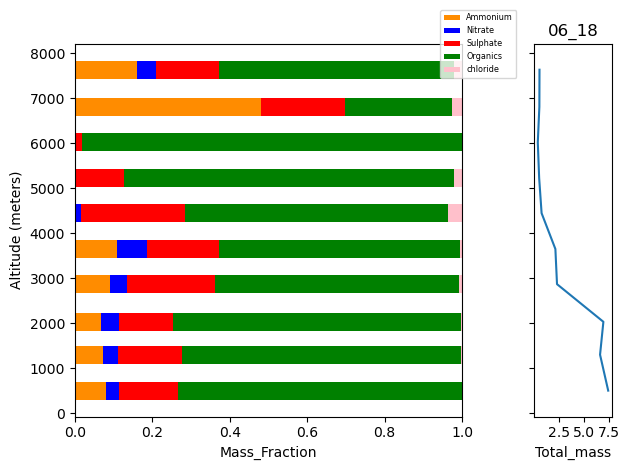

In [510]:
normal18 = (DAY18_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']+DAY18_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']+DAY18_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']+DAY18_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']+DAY18_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA'])
DAY18_subset_mean['AMS'] = normal8
DAY18_subset_mean = DAY18_subset_mean.sort_values(by= 'GPS_Altitude_THORNHILL')
y1 = DAY18_subset_mean['NH4_Ave_IsoK_STP_ZIEMBA']/normal18
y2 = DAY18_subset_mean['NO3_Ave_IsoK_STP_ZIEMBA']/normal18
y3 = DAY18_subset_mean['SO4_Ave_IsoK_STP_ZIEMBA']/normal18
y4 = DAY18_subset_mean['Org_Ave_IsoK_STP_ZIEMBA']/normal18
y5 = DAY18_subset_mean['Chl_Ave_IsoK_STP_ZIEMBA']/normal18
y6 = DAY18_subset_mean['mz44_Ave_IsoK_STP_ZIEMBA']/normal18
fig,ax = plt.subplots(1,2, width_ratios=[20, 4], sharey = "all")
ax[0].barh(DAY18_subset_mean['GPS_Altitude_THORNHILL'], y1, height = 400, color = "darkorange", label = 'Ammonium')
ax[0].barh(DAY18_subset_mean['GPS_Altitude_THORNHILL'], y2, left = y1, height = 400, color = "blue", label = 'Nitrate')
ax[0].barh(DAY18_subset_mean['GPS_Altitude_THORNHILL'], y3, left = y1+y2, height = 400, color = "red", label = 'Sulphate')
ax[0].barh(DAY18_subset_mean['GPS_Altitude_THORNHILL'], y4, left = y1+y2+y3, height = 400, color = "green", label = 'Organics')
#ax.barh(DAY18_subset_mean[' GPS_Altitude_THORNHILL'], y6, left = y1+y2+y3, height = 400, color = "palegreen", label = 'mz44')
ax[0].barh(DAY18_subset_mean['GPS_Altitude_THORNHILL'], y5, left = y1+y2+y3+y4, height = 400, color = "pink", label = 'chloride')
ax[1].plot(normal18, DAY18_subset_mean['GPS_Altitude_THORNHILL'], label = 'Total_mass')

ax[0].set_ylabel('Altitude (meters)')
ax[0].set_xlabel('Mass_Fraction')
ax[0].set_xlim(0,1)
ax[1].set_xlabel('Total_mass')
plt.title('06_18')

ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')
plt.tight_layout()

In [511]:

# Concatenate the dataframes vertically (along rows)
merged_df = pd.concat([DAY1000_subset_1000.describe(), DAY3000_subset_3000.describe(), DAY1000_subset_1000b.describe(), DAY3000_subset_3000b.describe(), DAY1000_subset_3.describe(), DAY3_subset_3000.describe(), DAY1000_subset_7.describe(), DAY7_subset_3000.describe(), DAY1000_subset_7b.describe(), DAY7b_subset_3000.describe(), DAY1000_subset_8.describe(), DAY8_subset_3000.describe(), DAY1000_subset_10.describe(), DAY10_subset_3000.describe(), DAY1000_subset_10b.describe(), DAY10b_subset_3000.describe(), DAY1000_subset_11.describe(), DAY11_subset_3000.describe(), DAY1000_subset_11b.describe(), DAY11b_subset_3000.describe(), DAY1000_subset_13.describe(), DAY13_subset_3000.describe(), DAY1000_subset_13b.describe(), DAY13b_subset_3000.describe(), DAY1000_subset_14.describe(), DAY14_subset_3000.describe(), DAY1000_subset_17.describe(), DAY17_subset_3000.describe(), DAY1000_subset_18.describe(), DAY18_subset_3000.describe()], axis=0)

# Reset the index of the merged dataframe
merged_df.reset_index(drop=False, inplace=True)

# Display the merged dataframe
merged_df
merged_df.to_csv('C:/Users/taiwoajayi/OneDrive - University of Arizona/python/chem_description.csv')